## Projet of Reinforcement Learning for Robotic Task Recognition in Event-Driven Environments


#### Team member :

- **MBATHE Paul**
- **Alexandre Desgrées du Loû**
- **LARNOUHET Matthieu**
- **VU Julien**


# AGENT 1: Gives an instruction to agent 2


In [1]:
# Install dependencies

!pip install pybullet
!pip install openthechests
!pip install gym matplotlib
!pip install imageio-ffmpeg
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics
!pip install wandb
!pip install opencv-python


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Agent 1


### 1.1. Introduction to the Problem


#### Reinforcement Learning for Pattern Recognition in Event Streams

This section implements a reinforcement learning solution to the "Open the Chests" environment, which represents a pattern recognition challenge in event-driven decision-making. In this environment, an agent 1 must learn to recognize specific event sequences and take appropriate actions based on those patterns.

The core challenge is teaching an agent to:

1. Process and understand sequential events
2. Identify meaningful patterns in these events
3. Make appropriate decisions based on recognized patterns
4. Balance between exploration (trying new actions) and exploitation (using known effective actions)

We'll explore different approaches to this problem, scaling from simple to complex solutions based on the environment difficulty.


### 1.2. Understanding the Environment: "Open the Chests"

#### The "Open the Chests" Environment

The **Open the Chests** environment introduces **event-driven decision-making**, where the robot must **recognize patterns in an event stream** and take the appropriate action. The environment simulates a scenario where **various activities generate a stream of events**, each representing a **significant observation**.

The robot's goal is to:

- **Recognize event signatures** in the stream.
- **Associate events with specific activities**.
- **Use this information to open the correct chest** by taking the appropriate action. Instructing agent 2 to do so

This requires the robot to **learn how to interpret event sequences** and **respond accordingly**.

### Environment Variants

There are three configurations of increasing difficulty:

1. **Easy (v0)**: Each chest is associated with a single event

   - Simple one-to-one mapping between event and action
   - No temporal dependency
   - Solvable using basic RL approaches

2. **Medium (v1)**: Each chest is associated with a sequence of 4 events

   - Requires tracking short event sequences
   - Introduces temporal dependencies
   - Needs memory mechanisms to track sequences

3. **Hard (v2)**: Each chest is associated with a complex sequence of 16 events
   - Requires tracking long-term dependencies
   - Needs advanced pattern recognition
   - Requires sophisticated memory mechanisms

These variants allow us to test different algorithmic approaches and architecture choices for reinforcement learning in sequential decision-making tasks.


### 1.3. Algorithms and Approach

#### Deep Reinforcement Learning Approach

To solve the "Open the Chests" environment, we employ **Deep Q-Learning (DQN)** with several advanced modifications based on the complexity of each environment variant.

#### Core Algorithm: Deep Q-Learning

Deep Q-Learning combines Q-Learning with deep neural networks to approximate the action-value function. The key components include:

1. **Experience Replay**: Stores experiences (state, action, reward, next_state) in a buffer and samples randomly to break correlations between consecutive samples
2. **Target Network**: A separate network that provides stable targets for the learning network
3. **Epsilon-Greedy Exploration**: Balances exploration and exploitation by selecting random actions with probability ε

#### Advanced Techniques (for more complex variants)

As the environment complexity increases, we incorporate additional techniques:

- **Long Short-Term Memory (LSTM)**: For v1 and v2, to capture temporal dependencies in event sequences
- **Transformer Layers**: For v2, to better model complex long-range dependencies
- **Double DQN**: Reduces overestimation bias in action values
- **Prioritized Experience Replay**: Samples more important transitions more frequently
- **Gradient Clipping**: Prevents exploding gradients during training
- **Soft Target Updates**: Gradually updates target network for more stable learning

Each environment variant uses an architecture tailored to its specific challenges.


### 1.4. Network Architecture

#### Model Architecture

Our implementation uses three different neural network architectures, each designed for a specific environment complexity level:

#### Simple MLP (v0)

For the simplest environment with one-to-one event-to-chest mapping, we use a Multi-Layer Perceptron:

- Input layer based on environment observation size
- Two hidden layers with ReLU activation and dropout
- Output layer with one node per action

#### LSTM Network (v1)

For the medium complexity environment with short sequences, we use a recurrent architecture:

- Embedding layer to process input features
- LSTM layer to maintain temporal context
- Layer normalization for training stability
- Fully connected output layers

#### LSTM + Transformer Architecture (v2)

For the complex environment with long sequences, we use a sophisticated architecture:

- Embedding layer with batch normalization
- LSTM layer for sequence processing
- Transformer encoder with self-attention
- Advanced pooling mechanism using attention weights
- Regularized output layers with strong dropout

Each architecture is specifically tuned to handle the temporal complexity requirements of its target environment.


#### 1.5. Network Architecture Code


In [2]:
# Imports
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import warnings
import os
import traceback
from pathlib import Path


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from register_envs import all_types, all_attributes, register_custom_envs
register_custom_envs()

# Ignore gym warnings
warnings.filterwarnings("ignore", category=UserWarning, module='gym')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='gym')
warnings.filterwarnings("ignore", category=FutureWarning, module='gym')
warnings.filterwarnings("ignore", message="Could not deserialize object*")
warnings.filterwarnings("ignore")


Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [3]:
class DQNModel(nn.Module):

    """
     Deep Q-Network model with architecture variants based on environment complexity.

    This class implements three different neural network architectures optimized for
    reinforcement learning in environments of varying complexity:

    - Version 0: Simple MLP network for environments with direct state-action mapping
      Architecture: Two fully connected layers with ReLU activations and dropout

    - Version 1: LSTM-based network for environments requiring short-term memory
      Architecture: Input embedding → LSTM → Fully connected layers

    - Version 2: Advanced LSTM+Transformer architecture for complex sequential environments
      Architecture: Input embedding → BatchNorm → LSTM → LayerNorm → Transformer → 
                   Attention mechanism → Fully connected output layers
    """

    def __init__(self, input_size, output_size, env_version=0):
        super(DQNModel, self).__init__()
        self.env_version = env_version
        self.lstm_hidden = None

        if env_version == 0:  # Simple MLP for v0
            self.hidden_size = 128
            self.network = nn.Sequential(
                nn.Linear(input_size, self.hidden_size),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_size)
            )

        elif env_version == 1:  # LSTM for v1
            self.hidden_size = 96
            self.embedding = nn.Linear(input_size, 64)
            self.lstm = nn.LSTM(64, self.hidden_size, batch_first=True)
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size, 64),
                nn.ReLU(),
                nn.Linear(64, output_size)
            )

        else:  # v2
            self.hidden_size = 128
            self.embedding = nn.Linear(input_size, self.hidden_size)
            self.emb_norm = nn.BatchNorm1d(self.hidden_size)
            self.lstm = nn.LSTM(
                self.hidden_size, self.hidden_size, num_layers=1, batch_first=True)
            self.norm1 = nn.LayerNorm(self.hidden_size)
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.hidden_size,
                nhead=4,
                dim_feedforward=128,
                dropout=0.3,
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(
                encoder_layer, num_layers=1)
            self.norm2 = nn.LayerNorm(self.hidden_size)
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, output_size)
            )

            self._init_weights()

    def _init_weights(self):
        if self.env_version == 2:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.orthogonal_(m.weight, gain=1.0)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0.0)

    def reset_hidden(self, batch_size=1):
        if self.env_version > 0:
            try:
                device = next(self.parameters()).device
                if self.env_version == 1:
                    num_layers = 1
                    hidden_size = self.hidden_size
                else:  # v2
                    num_layers = 1
                    hidden_size = self.hidden_size

                self.lstm_hidden = (
                    torch.zeros(num_layers, batch_size,
                                hidden_size, device=device),
                    torch.zeros(num_layers, batch_size,
                                hidden_size, device=device)
                )
            except (StopIteration, AttributeError):
                pass

    def detach_hidden(self):
        if self.env_version > 0 and self.lstm_hidden is not None:
            self.lstm_hidden = (
                self.lstm_hidden[0].detach(), self.lstm_hidden[1].detach())

    def forward(self, x):
        if self.env_version == 0:
            return self.network(x)

        elif self.env_version == 1:
            batch_size = x.size(0)
            if self.lstm_hidden is None or self.lstm_hidden[0].size(1) != batch_size:
                self.reset_hidden(batch_size)

            x = F.relu(self.embedding(x))
            lstm_out, self.lstm_hidden = self.lstm(x, self.lstm_hidden)
            x = lstm_out[:, -1, :]
            return self.fc(x)

        else:  # v2 with transformer
            batch_size = x.size(0)
            seq_len = x.size(1)

            if self.lstm_hidden is None or self.lstm_hidden[0].size(1) != batch_size:
                self.reset_hidden(batch_size)

            x = F.relu(self.embedding(x))

            orig_shape = x.shape
            x = x.reshape(-1, self.hidden_size)
            x = self.emb_norm(x)
            x = x.reshape(orig_shape)

            x = F.dropout(x, p=0.15, training=self.training)

            lstm_out, self.lstm_hidden = self.lstm(x, self.lstm_hidden)
            x = self.norm1(lstm_out)

            x = self.transformer(x)
            x = self.norm2(x)

            attn_weights = F.softmax(torch.matmul(
                x, x[:, -1, :].unsqueeze(2)), dim=1)
            x = torch.sum(x * attn_weights, dim=1)

            return self.fc(x)

### 1.6. Agent Implementation

#### The OpenTheChestsAgent Class

The `OpenTheChestsAgent` class is responsible for:

1. **Environment Interaction**: Communicates with the "Open the Chests" environment
2. **Experience Management**: Stores and samples transitions from experience replay buffer
3. **Action Selection**: Implements epsilon-greedy policy for exploration/exploitation
4. **Learning**: Updates the policy network based on experiences
5. **Evaluation**: Tests agent performance on unseen episodes

The agent is designed to handle all three environment variants (v0, v1, v2) with appropriate hyperparameters and model architectures for each.

### Key Features:

- **Version-specific Hyperparameters**: Each environment version uses optimized learning settings
- **Sequence Memory**: For v1 and v2, maintains a memory of recent observations
- **Training Stability**: Includes safeguards against training instability like gradient clipping
- **Adaptive Learning Rate**: Adjusts learning rate during training for v2
- **Model Persistence**: Saves and loads agent state for continued training
- **Performance Tracking**: Records training progress for analysis and visualization


#### 1.6.1 Memory


In [4]:
class ReplayMemory:
    """
    A replay buffer for storing and sampling experiences in reinforcement learning.

    This class implements a fixed-size memory that stores transitions (state, action, 
    next_state, reward) and allows random sampling of stored experiences for training.
    When capacity is reached, oldest experiences are automatically discarded.

    """

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        actual_batch_size = min(batch_size, len(self.memory))
        if actual_batch_size == 0:
            return []
        return random.sample(self.memory, actual_batch_size)

    def __len__(self):
        return len(self.memory)

### 1.6.2 Prioritized Experience Replay memory for more efficient reinforcement learning.


In [5]:

class PrioritizedReplayMemory:
    """
    Prioritized Experience Replay memory for more efficient reinforcement learning.

    This class implements a fixed-size memory with prioritized sampling, which
    gives higher probability to experiences with higher temporal-difference (TD)
    errors. This approach focuses training on the most informative transitions,
    leading to faster and more stable learning compared to uniform sampling.

    Parameters:
    -----------
    capacity : int
        Maximum number of transitions to store in the buffer.
    alpha : float, default=0.6
        Determines how much prioritization is used. 
        α = 0 corresponds to uniform sampling, while α = 1 corresponds to 
        sampling strictly according to priorities.
    beta : float, default=0.4
        Controls the extent of importance sampling weight correction.
        β = 1 fully compensates for the non-uniform sampling.
        This value is gradually increased to 1 during training.
    beta_increment : float, default=0.001
        The amount to increase beta after each sampling operation,
        gradually moving from biased sampling to compensated sampling.

    """

    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.beta = beta    # Importance sampling correction
        self.beta_increment = beta_increment  # Gradually increase beta to 1
        self.memory = []
        self.priorities = np.ones((capacity,), dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.priorities[self.position] = self.max_priority
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) == 0:
            return []

        self.beta = min(1.0, self.beta + self.beta_increment)

        priorities = self.priorities[:len(self.memory)]
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), min(batch_size, len(self.memory)),
                                   replace=False, p=probs)

        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        samples = [self.memory[idx] for idx in indices]
        return samples, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            priority = abs(error) + 1e-5
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.memory)

### 1.6.3. Agent Code - Core Methods


In [6]:

class OpenTheChestsAgent:
    """
    A reinforcement learning agent designed to solve the OpenTheChests environments
    of varying complexity using different neural network architectures.

    This agent implements Deep Q-Network (DQN) variants with environment-specific
    architectures: MLP for simple environments (v0), LSTM for medium complexity (v1),
    and LSTM+Transformer for complex environments (v2). The agent supports various
    advanced reinforcement learning techniques including:

    - Experience replay (standard and prioritized)
    - Target networks with soft updates
    - Double DQN (for complex environments)
    - Epsilon-greedy exploration with decay
    - Gradient clipping for stability
    - Learning rate scheduling
    - Automatic model reset when learning diverges
    - LSTM hidden state management for sequential environments

    Each environment version uses tailored hyperparameters and architecture:
    - v0: Simple MLP network for direct state-action mapping
    - v1: LSTM-based network for short sequential patterns
    - v2: Advanced LSTM+Transformer network with additional stability techniques
         for long sequential dependencies

    The agent automatically adapts to the environment version, handles observation
    preprocessing, manages model training, evaluation, saving/loading, and provides
    performance visualization tools.
    """

    def __init__(self, env_name, device=None):
        if device:
            self.device = torch.device(device)
        else:
            self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        try:
            self.env = gym.make(env_name)
        except gym.error.Error as e:
            print(
                f"FATAL: Could not create environment {env_name}. Error: {e}")
            raise

        self.env_name = env_name

        if 'v0' in env_name:
            self.version = 0
            self.sequence_length = 1
        elif 'v1' in env_name:
            self.version = 1
            self.sequence_length = 8
        else:  # v2
            self.version = 2
            self.sequence_length = 10

        if self.version == 0:
            self.BATCH_SIZE = 64
            self.GAMMA = 0.98
            self.EPS_START = 0.95
            self.EPS_END = 0.05
            self.EPS_DECAY = 800
            self.TAU = 0.01
            self.LR = 3e-4
            self.MEMORY_SIZE = 20000
            self.TARGET_UPDATE_FREQ = 5
            self.LEARNING_STARTS = 500
            self.USE_PRIORITIZED_REPLAY = False
        elif self.version == 1:
            self.BATCH_SIZE = 64
            self.GAMMA = 0.99
            self.EPS_START = 0.9
            self.EPS_END = 0.05
            self.EPS_DECAY = 1000
            self.TAU = 0.01
            self.LR = 1e-4
            self.MEMORY_SIZE = 30000
            self.TARGET_UPDATE_FREQ = 10
            self.LEARNING_STARTS = 500
            self.LSTM_HIDDEN_RESET_FREQ = 6
            self.WEIGHT_DECAY = 1e-5
            self.USE_PRIORITIZED_REPLAY = False
        else:  # v2
            self.BATCH_SIZE = 32
            self.GAMMA = 0.99
            self.EPS_START = 1.0
            self.EPS_END = 0.05
            self.EPS_DECAY = 3000  # Slower epsilon decay for better exploration
            self.TAU = 0.001  # Lower TAU for slower target updates
            self.LR = 5e-5   # Lower learning rate
            self.MEMORY_SIZE = 40000
            self.TARGET_UPDATE_FREQ = 10
            self.LEARNING_STARTS = 1000
            self.LSTM_HIDDEN_RESET_FREQ = 5
            self.WEIGHT_DECAY = 1e-4
            self.USE_PRIORITIZED_REPLAY = True
            self.USE_DOUBLE_DQN = True
            self.ACTION_THRESHOLD = 0.4
            self.GRADIENT_CLIP = 1.0
            self.DROPOUT_RATE = 0.3

        try:
            temp_obs = self.env.reset()
        except Exception as e:
            print(
                f"FATAL: Error resetting environment '{env_name}' during init: {e}")
            raise

        if isinstance(temp_obs, dict):
            self.obs_keys = list(temp_obs.keys())
            flat_obs = self._flatten_observation(temp_obs)
        else:
            self.obs_keys = None
            try:
                flat_obs = temp_obs.flatten()
            except AttributeError:
                flat_obs = np.array([temp_obs])
        input_size = len(flat_obs)

        try:
            self.n_actions = self.env.action_space.n
        except AttributeError:
            print(
                f"FATAL: Environment {env_name} does not have a discrete action space 'n'.")
            raise

        if self.version > 0:
            self.state_memory = deque(maxlen=self.sequence_length)

        self.policy_net = DQNModel(
            input_size, self.n_actions, self.version).to(self.device)
        self.target_net = DQNModel(
            input_size, self.n_actions, self.version).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        wd = getattr(self, 'WEIGHT_DECAY', 0.0)
        if self.version >= 1:
            self.optimizer = optim.AdamW(
                self.policy_net.parameters(),
                lr=self.LR,
                weight_decay=wd,
                amsgrad=True
            )
            if self.version == 2:
                self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                    self.optimizer,
                    T_max=2000,
                    eta_min=self.LR/10
                )
        else:
            self.optimizer = optim.Adam(
                self.policy_net.parameters(), lr=self.LR)

        if self.USE_PRIORITIZED_REPLAY:
            self.memory = PrioritizedReplayMemory(self.MEMORY_SIZE)
        else:
            self.memory = ReplayMemory(self.MEMORY_SIZE)

        self.steps_done = 0
        self.training_rewards = []
        self.eval_rewards = []
        self.losses = []
        self.episodes_since_reset = 0
        self.no_action_counts = []

    def _flatten_observation(self, obs):
        if not isinstance(obs, dict):
            try:
                return obs.flatten().astype(np.float32)
            except AttributeError:
                return np.array([obs], dtype=np.float32)

        flat_obs = []
        if not hasattr(self, 'obs_keys') or self.obs_keys is None:
            self.obs_keys = list(obs.keys())

        for key in self.obs_keys:
            val = obs.get(key)
            if val is None:
                flat_obs.append(0.0)
                continue
            if isinstance(val, np.ndarray):
                flat_obs.extend(val.flatten())
            elif np.isscalar(val):
                flat_obs.append(val)
            else:
                try:
                    flat_obs.append(float(val))
                except (TypeError, ValueError):
                    flat_obs.append(0.0)
        return np.array(flat_obs, dtype=np.float32)

    def preprocess_state(self, state):
        flat_state = self._flatten_observation(state)

        try:
            if self.version == 0:
                input_dim = self.policy_net.network[0].in_features
            else:
                input_dim = self.policy_net.embedding.in_features
        except (AttributeError, IndexError):
            return None

        if flat_state.shape[0] != input_dim:
            return None

        if self.version == 0:
            return torch.tensor(flat_state, dtype=torch.float32, device=self.device).unsqueeze(0)
        else:
            self.state_memory.append(flat_state)

            if len(self.state_memory) < self.sequence_length:
                padding = [np.zeros_like(
                    flat_state)] * (self.sequence_length - len(self.state_memory))
                sequence = padding + list(self.state_memory)
            else:
                sequence = list(self.state_memory)

            sequence_np = np.array(sequence, dtype=np.float32)
            return torch.tensor(sequence_np, dtype=torch.float32, device=self.device).unsqueeze(0)

    def select_action(self, state_tensor, evaluate=False):
        if state_tensor is None:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)

        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)

        # Increment step counter except in evaluation
        if not evaluate:
            self.steps_done += 1

        # Use epsilon-greedy policy
        if evaluate or random.random() > eps_threshold:
            self.policy_net.eval()
            with torch.no_grad():
                action_values = self.policy_net(state_tensor)

                if self.version == 2 and not evaluate:
                    action_max_value = action_values.max().item()
                    do_nothing_value = action_values[0, 0].item()

                    if do_nothing_value > action_max_value - self.ACTION_THRESHOLD:
                        action = torch.tensor(
                            [[0]], device=self.device, dtype=torch.long)
                    else:
                        action = action_values.max(1)[1].view(1, 1)
                else:
                    action = action_values.max(1)[1].view(1, 1)

            if not evaluate:
                self.policy_net.train()
            return action
        else:
            if self.version == 2 and random.random() < 0.3:
                return torch.tensor([[0]], device=self.device, dtype=torch.long)
            else:
                return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE or self.steps_done < self.LEARNING_STARTS:
            return 0.0

        self.policy_net.train()
        self.target_net.eval()

        if self.USE_PRIORITIZED_REPLAY:
            transitions, indices, weights = self.memory.sample(self.BATCH_SIZE)
            weights = weights.to(self.device)
            if not transitions:
                return 0.0
        else:
            transitions = self.memory.sample(self.BATCH_SIZE)
            if not transitions:
                return 0.0

        batch = Transition(*zip(*transitions))

        # Filter valid states
        valid_indices = [i for i, s in enumerate(batch.state) if s is not None]
        if len(valid_indices) < self.BATCH_SIZE // 4:
            return 0.0

        state_batch_list = [batch.state[i] for i in valid_indices]
        action_batch_list = [batch.action[i] for i in valid_indices]
        reward_batch_list = [batch.reward[i] for i in valid_indices]
        next_state_batch_list = [batch.next_state[i] for i in valid_indices]

        state_batch = torch.cat(state_batch_list)
        action_batch = torch.cat(action_batch_list)
        reward_batch = torch.cat(reward_batch_list)

        current_batch_size = state_batch.size(0)

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, next_state_batch_list)),
            device=self.device, dtype=torch.bool
        )
        non_final_next_states_list = [
            s for s in next_state_batch_list if s is not None]

        # Concatenate non-final next states
        if len(non_final_next_states_list) > 0:
            non_final_next_states = torch.cat(non_final_next_states_list)
        else:
            non_final_next_states = None
        if self.version > 0:
            self.policy_net.reset_hidden(current_batch_size)
        state_action_values = self.policy_net(
            state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(current_batch_size, device=self.device)

        if non_final_next_states is not None:
            if self.version > 0:
                self.target_net.reset_hidden(non_final_next_states.size(0))

            with torch.no_grad():
                if self.version == 2 and self.USE_DOUBLE_DQN:
                    if self.version > 0:
                        self.policy_net.reset_hidden(
                            non_final_next_states.size(0))
                    next_action = self.policy_net(non_final_next_states).max(1)[
                        1].unsqueeze(1)
                    next_state_values[non_final_mask] = self.target_net(
                        non_final_next_states).gather(1, next_action).squeeze(1)
                else:
                    next_state_values[non_final_mask] = self.target_net(
                        non_final_next_states).max(1)[0]

        # Calculate target Q-values
        expected_state_action_values = (
            next_state_values * self.GAMMA) + reward_batch

        if self.version < 2:
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values,
                             expected_state_action_values.unsqueeze(1))
        else:
            if self.USE_PRIORITIZED_REPLAY:
                td_errors = state_action_values.squeeze() - expected_state_action_values
                loss = (td_errors.pow(2) * weights).mean()

                self.memory.update_priorities(
                    indices,
                    td_errors.abs().detach().cpu().numpy()
                )
            else:
                criterion = nn.MSELoss()
                loss = criterion(state_action_values,
                                 expected_state_action_values.unsqueeze(1))

        if self.version == 2 and len(valid_indices) > 1:
            action_indices = [a.item() for a in action_batch]
            non_zero_actions = sum([1 for a in action_indices if a > 0])
            action_ratio = non_zero_actions / len(action_indices)

            if action_ratio > 0.85:
                loss += 0.02 * action_ratio
            elif action_ratio < 0.05 and self.steps_done > 10000:
                loss += 0.02 * (1 - action_ratio)

        # Optimization
        self.optimizer.zero_grad()
        loss.backward()

        if self.version == 2:
            torch.nn.utils.clip_grad_value_(
                self.policy_net.parameters(), self.GRADIENT_CLIP)
        else:
            torch.nn.utils.clip_grad_norm_(
                self.policy_net.parameters(), max_norm=1.0)

        self.optimizer.step()

        if self.steps_done % self.TARGET_UPDATE_FREQ == 0:
            self._soft_update_target()

        return loss.item()

    def _soft_update_target(self):
        """Soft update of target network parameters."""
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * \
                self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)

    def _reset_networks_if_needed(self):
        """Reset networks if loss is diverging."""
        if self.version == 2 and len(self.losses) > 100:
            recent_avg_loss = np.mean(self.losses[-20:])
            prev_avg_loss = np.mean(
                self.losses[-40:-20]) if len(self.losses) >= 40 else recent_avg_loss

            if recent_avg_loss > 2.0 * prev_avg_loss and recent_avg_loss > 8.0:
                print(
                    f"\nRESETTING NETWORKS: Loss increasing significantly (recent: {recent_avg_loss:.4f}, previous: {prev_avg_loss:.4f})")

                try:
                    torch.save({
                        'policy_net': self.policy_net.state_dict(),
                        'target_net': self.target_net.state_dict(),
                        'optimizer': self.optimizer.state_dict(),
                    }, f"pre_reset_backup_{self.env_name}.pth")
                except Exception:
                    pass

                # Recreate networks
                input_size = self.policy_net.embedding.in_features

                self.policy_net = DQNModel(
                    input_size, self.n_actions, self.version).to(self.device)
                self.target_net = DQNModel(
                    input_size, self.n_actions, self.version).to(self.device)
                self.target_net.load_state_dict(self.policy_net.state_dict())
                self.target_net.eval()

                self.optimizer = optim.AdamW(
                    self.policy_net.parameters(),
                    lr=self.LR * 0.5,
                    weight_decay=self.WEIGHT_DECAY,
                    amsgrad=True
                )

                if hasattr(self, 'scheduler'):
                    self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                        self.optimizer,
                        T_max=2000,
                        eta_min=self.LR/10
                    )

                self.episodes_since_reset = 0
                return True

        return False

    def train_agent(self, num_episodes=1000, max_steps_per_episode=1000, eval_interval=50, eval_episodes=10):
        """Main training loop for the agent."""
        print(f"Starting training for {self.env_name} on {self.device}...")
        best_eval_reward = float('-inf')
        episode_rewards = []
        episode_losses = []
        eval_interval = max(1, eval_interval)
        reset_occurred = False
        no_action_counts = []

        for episode in range(num_episodes):
            if self.version == 2 and episode > 50 and episode % 50 == 0:
                reset_occurred = self._reset_networks_if_needed()

            try:
                raw_state = self.env.reset()
            except Exception as e:
                print(
                    f"Error resetting environment at start of episode {episode}: {e}")
                continue

            current_total_reward = 0
            steps_in_episode = 0
            losses_this_episode = []
            no_action_count = 0

            if self.version > 0:
                self.state_memory.clear()
                self.policy_net.reset_hidden(batch_size=1)
                self.target_net.reset_hidden(batch_size=1)

            state_tensor = self.preprocess_state(raw_state)
            if state_tensor is None:
                print(
                    f"Error preprocessing initial state in episode {episode}. Skipping episode.")
                continue

            for step in range(max_steps_per_episode):
                if self.version > 0 and step > 0 and step % self.LSTM_HIDDEN_RESET_FREQ == 0:
                    self.policy_net.detach_hidden()

                action_tensor = self.select_action(
                    state_tensor, evaluate=False)
                action_index = action_tensor.item()

                if action_index == 0:
                    no_action_count += 1

                one_hot_action = np.zeros(self.n_actions, dtype=np.int32)
                one_hot_action[action_index] = 1

                try:
                    next_raw_state, reward, done, info = self.env.step(
                        one_hot_action)
                except Exception as e:
                    print(
                        f"Error during environment step {step} in episode {episode}: {e}")
                    done = True
                    next_raw_state = None
                    reward = 0

                current_total_reward += reward
                reward_tensor = torch.tensor(
                    [reward], device=self.device, dtype=torch.float32)

                if not done and next_raw_state is not None:
                    next_state_tensor = self.preprocess_state(next_raw_state)
                    if next_state_tensor is None:
                        done = True
                        next_state_tensor = None
                else:
                    next_state_tensor = None

                if state_tensor is not None:
                    self.memory.push(state_tensor, action_tensor,
                                     next_state_tensor, reward_tensor)

                state_tensor = next_state_tensor

                loss = self.optimize_model()
                if loss > 0:
                    losses_this_episode.append(loss)

                steps_in_episode += 1
                if done:
                    break

            # Update scheduler for v2
            if self.version == 2 and hasattr(self, 'scheduler'):
                self.scheduler.step()

            episode_rewards.append(current_total_reward)
            avg_loss = np.mean(
                losses_this_episode) if losses_this_episode else 0.0
            episode_losses.append(avg_loss)
            no_action_counts.append(no_action_count)

            if self.version == 2 and avg_loss > 15.0 and not reset_occurred:
                print(
                    f"WARNING: Very high loss detected: {avg_loss:.4f}. Consider model reset.")

            if episode % eval_interval == 0 or episode == num_episodes - 1:
                try:
                    if self.version > 0:
                        self.policy_net.lstm_hidden = None

                    eval_reward = self.evaluate(
                        num_episodes=eval_episodes, max_steps=max_steps_per_episode)
                    self.eval_rewards.append(eval_reward)
                    current_epsilon = self.EPS_END + \
                        (self.EPS_START - self.EPS_END) * \
                        math.exp(-1. * self.steps_done / self.EPS_DECAY)

                    current_lr = self.optimizer.param_groups[0]['lr']
                    print(f"Ep {episode}/{num_episodes} | Steps: {steps_in_episode} | Train R: {current_total_reward:.2f} | "
                          f"Eval R: {eval_reward:.2f} | Avg Loss: {avg_loss:.4f} | Epsilon: {current_epsilon:.3f} | LR: {current_lr:.6f}")

                    if eval_reward > best_eval_reward:
                        best_eval_reward = eval_reward
                        self.save_model(
                            Path("weights") / "agent_1" / f"agent_{self.env_name}.pth")
                        print(
                            f"    New best model saved with Eval Reward: {best_eval_reward:.2f}")
                except Exception as e:
                    print(f"Error during evaluation at episode {episode}: {e}")
                    self.eval_rewards.append(float('-inf'))

            if self.version == 2 and episode > 0 and episode % 250 == 0:
                checkpoint_path = Path(
                    "weights") / "agent_1" / "checkpoints" / f"checkpoint_ep{episode}_{self.env_name}.pth"
                self.save_model(checkpoint_path)
                print(f"    Periodic checkpoint saved at episode {episode}")

            self.episodes_since_reset += 1
            self.no_action_counts = no_action_counts

        self.training_rewards = episode_rewards
        self.losses = episode_losses
        print(
            f"\nTraining complete for {self.env_name}. Best Eval Reward: {best_eval_reward:.2f}")
        self.save_model(Path("weights") / "agent_1" /
                        "final_models" / f"final_agent_{self.env_name}.pth")

        return episode_rewards, episode_losses

    def evaluate(self, num_episodes=10, max_steps=1000):
        """Evaluates agent with greedy policy."""
        self.policy_net.eval()
        total_rewards = []
        no_action_counts = []

        for episode in range(num_episodes):
            try:
                raw_state = self.env.reset()
            except Exception as e:
                print(f"Error resetting environment during evaluation: {e}")
                continue

            episode_reward = 0
            no_action_count = 0

            if self.version > 0:
                self.state_memory.clear()
                self.policy_net.reset_hidden(batch_size=1)

            state_tensor = self.preprocess_state(raw_state)
            if state_tensor is None:
                continue

            for step in range(max_steps):
                if self.version > 0 and step > 0 and step % (self.LSTM_HIDDEN_RESET_FREQ // 2) == 0:
                    self.policy_net.detach_hidden()

                action_tensor = self.select_action(state_tensor, evaluate=True)
                action_index = action_tensor.item()

                if action_index == 0:
                    no_action_count += 1

                one_hot_action = np.zeros(self.n_actions, dtype=np.int32)
                one_hot_action[action_index] = 1

                # Take action
                try:
                    next_raw_state, reward, done, info = self.env.step(
                        one_hot_action)
                except Exception as e:
                    print(f"Error during evaluation step: {e}")
                    done = True
                    next_raw_state = None
                    reward = 0

                episode_reward += reward

                if done:
                    break

                # Move to next state
                if next_raw_state is not None:
                    state_tensor = self.preprocess_state(next_raw_state)
                    if state_tensor is None:
                        break
                else:
                    break

            # Store results
            total_rewards.append(episode_reward)
            no_action_counts.append(no_action_count)

        # Calculate average reward
        avg_reward = np.mean(total_rewards) if total_rewards else float('-inf')
        return avg_reward

    def save_model(self, path):
        """Saves model and training data."""
        try:
            current_hyperparameters = {
                'BATCH_SIZE': self.BATCH_SIZE, 'GAMMA': self.GAMMA,
                'EPS_START': self.EPS_START, 'EPS_END': self.EPS_END,
                'EPS_DECAY': self.EPS_DECAY, 'TAU': self.TAU, 'LR': self.LR,
                'MEMORY_SIZE': self.MEMORY_SIZE,
                'TARGET_UPDATE_FREQ': self.TARGET_UPDATE_FREQ,
                'LEARNING_STARTS': self.LEARNING_STARTS,
                'LSTM_HIDDEN_RESET_FREQ': getattr(self, 'LSTM_HIDDEN_RESET_FREQ', 1),
                'sequence_length': self.sequence_length,
                'weight_decay': getattr(self, 'WEIGHT_DECAY', 0.0),
                'use_prioritized_replay': getattr(self, 'USE_PRIORITIZED_REPLAY', False),
                'use_double_dqn': getattr(self, 'USE_DOUBLE_DQN', False),
                'gradient_clip': getattr(self, 'GRADIENT_CLIP', 1.0)
            }

            torch.save({
                'policy_net_state_dict': self.policy_net.state_dict(),
                'target_net_state_dict': self.target_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'steps_done': self.steps_done,
                'training_rewards': self.training_rewards,
                'eval_rewards': self.eval_rewards,
                'losses': self.losses,
                'no_action_counts': getattr(self, 'no_action_counts', []),
                'version': self.version,
                'env_name': self.env_name,
                'hyperparameters': current_hyperparameters,
                'scheduler_state': self.scheduler.state_dict() if hasattr(self, 'scheduler') else None
            }, path)
            print(f"Model saved to {path}")
        except Exception as e:
            print(f"Error saving model: {e}")

    def load_model(self, path):
        """Loads model state and training progress from a checkpoint."""
        print(f"Loading model from {path}...")
        if not os.path.exists(path):
            print(f"Error: Model file not found at {path}. Cannot load.")
            return False

        try:
            checkpoint = torch.load(
                path, map_location=self.device, weights_only=False)

            loaded_version = checkpoint.get('version', -1)
            loaded_env_name = checkpoint.get('env_name', 'unknown')
            if loaded_version != self.version or loaded_env_name != self.env_name:
                print(f"Warning: Loading model from different version/env! "
                      f"Loaded: v{loaded_version} ({loaded_env_name}), "
                      f"Current: v{self.version} ({self.env_name}). May cause issues.")

            self.policy_net.load_state_dict(
                checkpoint['policy_net_state_dict'])
            self.target_net.load_state_dict(
                checkpoint['target_net_state_dict'])
            try:
                self.optimizer.load_state_dict(
                    checkpoint['optimizer_state_dict'])
                for state in self.optimizer.state.values():
                    for k, v in state.items():
                        if isinstance(v, torch.Tensor):
                            state[k] = v.to(self.device)
            except Exception as e:
                print(
                    f"Warning: Could not load optimizer state dict. Optimizer re-initialized. Error: {e}")

            self.steps_done = checkpoint.get('steps_done', 0)
            self.training_rewards = checkpoint.get('training_rewards', [])
            self.eval_rewards = checkpoint.get('eval_rewards', [])
            self.losses = checkpoint.get('losses', [])
            self.no_action_counts = checkpoint.get('no_action_counts', [])

            loaded_hp = checkpoint.get('hyperparameters', {})
            if loaded_hp:
                print("   Loading hyperparameters from checkpoint...")
                self.BATCH_SIZE = loaded_hp.get('BATCH_SIZE', self.BATCH_SIZE)
                self.GAMMA = loaded_hp.get('GAMMA', self.GAMMA)
                self.EPS_START = loaded_hp.get('EPS_START', self.EPS_START)
                self.EPS_END = loaded_hp.get('EPS_END', self.EPS_END)
                self.EPS_DECAY = loaded_hp.get('EPS_DECAY', self.EPS_DECAY)
                self.TAU = loaded_hp.get('TAU', self.TAU)
                loaded_lr = loaded_hp.get('LR', self.LR)
                if loaded_lr != self.LR:
                    print(
                        f"   Updating optimizer LR to loaded value: {loaded_lr}")
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = loaded_lr
                self.LR = loaded_lr
                self.MEMORY_SIZE = loaded_hp.get(
                    'MEMORY_SIZE', self.MEMORY_SIZE)
                self.TARGET_UPDATE_FREQ = loaded_hp.get(
                    'TARGET_UPDATE_FREQ', self.TARGET_UPDATE_FREQ)
                self.LEARNING_STARTS = loaded_hp.get(
                    'LEARNING_STARTS', self.LEARNING_STARTS)

                self.LSTM_HIDDEN_RESET_FREQ = loaded_hp.get(
                    'LSTM_HIDDEN_RESET_FREQ', 5)

                self.WEIGHT_DECAY = loaded_hp.get(
                    'weight_decay', getattr(self, 'WEIGHT_DECAY', 0.0))
                self.RESET_EVERY_EPISODE = loaded_hp.get(
                    'RESET_EVERY_EPISODE', getattr(self, 'RESET_EVERY_EPISODE', False))
                self.CLIP_GRAD_VALUE = loaded_hp.get(
                    'CLIP_GRAD_VALUE', getattr(self, 'CLIP_GRAD_VALUE', 1.0))

                loaded_seq_len = loaded_hp.get(
                    'sequence_length', self.sequence_length)
                if loaded_seq_len != self.sequence_length:
                    print(
                        f"   Sequence length changed from {self.sequence_length} to {loaded_seq_len}. Updating.")
                    self.sequence_length = loaded_seq_len
                    if self.version > 0 and hasattr(self, 'state_memory'):
                        self.state_memory = deque(maxlen=self.sequence_length)

            if hasattr(self, 'scheduler') and 'scheduler_state' in checkpoint and checkpoint['scheduler_state']:
                try:
                    self.scheduler.load_state_dict(
                        checkpoint['scheduler_state'])
                except Exception as e:
                    print(f"Warning: Could not load scheduler state: {e}")

            print(
                f"Model loaded successfully. Resuming from step {self.steps_done}.")

            # Reset hidden states
            self.policy_net.to(self.device)
            self.target_net.to(self.device)
            self.target_net.eval()
            self.policy_net.train()

            if self.version > 0:
                self.policy_net.lstm_hidden = None
                self.target_net.lstm_hidden = None

            return True
        except FileNotFoundError:
            print(f"Error: Model file not found at {path}.")
            return False
        except Exception as e:
            print(f"Error loading model checkpoint: {e}. Check compatibility.")
            traceback.print_exc()
            return False

    def plot_performance(self, save_path=None, show=True):
        """Plots performance curves."""
        plt.figure(figsize=(16, 6))

        # Plot Training Rewards
        plt.subplot(1, 2, 1)
        if self.training_rewards:
            rewards_np = np.array(self.training_rewards)
            plt.plot(rewards_np, 'b-', alpha=0.3, label='Per episode')

            # Add moving average
            window_size = min(50, len(rewards_np)//5)
            if window_size > 1:
                smoothed = np.convolve(rewards_np, np.ones(
                    window_size)/window_size, mode='valid')
                plt.plot(np.arange(window_size-1, len(rewards_np)), smoothed, 'b-',
                         linewidth=2, label=f'Moving average ({window_size})')

        plt.title(f'Training Rewards - {self.env_name}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Plot Evaluation Rewards
        plt.subplot(1, 2, 2)
        if self.eval_rewards:
            eval_interval = max(1, len(self.training_rewards) // len(self.eval_rewards)) \
                if self.training_rewards else 50
            eval_x = np.arange(len(self.eval_rewards)) * eval_interval
            plt.plot(eval_x, self.eval_rewards, 'r-o',
                     label='Evaluation performance')

            # Add trend line
            if len(self.eval_rewards) > 2:
                z = np.polyfit(eval_x, self.eval_rewards, 1)
                p = np.poly1d(z)
                plt.plot(eval_x, p(eval_x), 'k--', alpha=0.7, label='Trend')

        plt.title(f'Evaluation Performance - {self.env_name}')
        plt.xlabel('Approximate Episode')
        plt.ylabel('Average Reward')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Performance plot saved to {save_path}")

        if show:
            plt.show()

        plt.close()

### 1.7. Training Multiple Environments


In [7]:
def train_and_evaluate_all_environments(plot_combined=True, load_if_exists=False):
    """Trains or loads agents for all defined environments and evaluates them."""
    # --- Environment Registration ---
    script_dir = os.path.dirname(os.path.abspath(
        __file__)) if '__file__' in locals() else '.'
    register_envs_path = os.path.join(script_dir, 'register_envs.py')
    try:
        if os.path.exists(register_envs_path):
            from register_envs import register_custom_envs
            register_custom_envs()
            print("Custom environments registered.")
        else:
            print(
                f"Warning: '{register_envs_path}' not found. Assuming environments are registered elsewhere.")
    except ImportError:
        print(
            f"Warning: Failed to import 'register_custom_envs' from '{register_envs_path}'.")
    except Exception as e:
        print(f"Error during environment registration: {e}")

    configs = [
        {"env_name": "OpenTheChests-v0", "episodes": 2500,
            "eval_interval": 50, "max_steps": 250},
        {"env_name": "OpenTheChests-v1", "episodes": 2500,
            "eval_interval": 50, "max_steps": 500},  # V1
        {"env_name": "OpenTheChests-v2", "episodes": 2500,
            "eval_interval": 50, "max_steps": 1000}  # V2
    ]

    all_agents = []
    all_eval_rewards = {}

    # --- Loop Through Configurations ---
    for config in configs:
        print(f"\n{'='*10} Processing agent for {config['env_name']} {'='*10}")
        try:
            agent = OpenTheChestsAgent(config['env_name'])
            model_loaded = False
            model_path_final = Path(
                "weights") / "agent_1" / "final_models" / f"final_agent_{config['env_name']}.pth"
            model_path_best = Path("weights") / "agent_1" / \
                f"agent_{config['env_name']}.pth"

            if load_if_exists:
                if os.path.exists(model_path_best):
                    print(f"Attempting to load best model: {model_path_best}")
                    if agent.load_model(model_path_best):
                        model_loaded = True
                elif os.path.exists(model_path_final):
                    print(
                        f"Best model not found. Attempting to load final model: {model_path_final}")
                    if agent.load_model(model_path_final):
                        model_loaded = True

            if not model_loaded:
                if load_if_exists:
                    print(
                        f"No existing model found for {config['env_name']}. Starting training.")
                else:
                    print(
                        f"load_if_exists=False. Starting training for {config['env_name']}.")
                _, _ = agent.train_agent(
                    num_episodes=config['episodes'],
                    eval_interval=config['eval_interval'],
                    max_steps_per_episode=config['max_steps'],
                    eval_episodes=20)
            else:
                print(
                    f"Skipping training for {config['env_name']} as model was loaded.")
                if not agent.eval_rewards:
                    print(
                        "   Running evaluation on loaded model to populate eval_rewards for plotting...")
                    eval_reward = agent.evaluate(
                        num_episodes=20, max_steps=config['max_steps'])
                    agent.eval_rewards.append(eval_reward)

            # --- Final Evaluation ---
            print(f"\nRunning final evaluation for {config['env_name']}...")
            final_eval_score = agent.evaluate(
                num_episodes=50, max_steps=config['max_steps'])
            print(
                f"Final evaluation score for {config['env_name']} (50 episodes): {final_eval_score:.2f}")

            all_agents.append(agent)
            all_eval_rewards[config['env_name']] = agent.eval_rewards

        except gym.error.Error as e:
            print(
                f"Gym environment error for {config['env_name']}: {e}. Skipping this environment.")
        except Exception as e:
            print(
                f"An unexpected error occurred for {config['env_name']}: {e}")
            traceback.print_exc()

    if all_agents:
        n_agents = len(all_agents)
        if n_agents > 0:
            fig = plt.figure(figsize=(20, 6 * n_agents))
            gs = plt.GridSpec(n_agents, 3, figure=fig)

            for i, agent in enumerate(all_agents):
                ax1 = fig.add_subplot(gs[i, 0])
                if hasattr(agent, 'training_rewards') and agent.training_rewards:
                    rewards_np = np.array(agent.training_rewards)
                    ax1.plot(rewards_np, 'b-', alpha=0.3, label='Per episode')

                    window_size = min(50, max(5, len(rewards_np)//10))
                    if window_size > 1 and len(rewards_np) > window_size:
                        smoothed = np.convolve(rewards_np, np.ones(
                            window_size)/window_size, mode='valid')
                        ax1.plot(np.arange(window_size-1, len(rewards_np)), smoothed, 'b-',
                                 linewidth=2, label=f'Moving average ({window_size})')
                    ax1.legend()

                ax1.set_title(f'Training Rewards - {agent.env_name}')
                ax1.set_xlabel('Episode')
                ax1.set_ylabel('Total Reward')
                ax1.grid(True, alpha=0.3)

                ax2 = fig.add_subplot(gs[i, 1])
                if hasattr(agent, 'eval_rewards') and agent.eval_rewards:
                    eval_interval = max(1, len(agent.training_rewards) // len(agent.eval_rewards)) \
                        if hasattr(agent, 'training_rewards') and agent.training_rewards else 50
                    eval_x = np.arange(len(agent.eval_rewards)) * eval_interval

                    ax2.plot(eval_x, agent.eval_rewards, 'r-o',
                             markersize=4, label='Performance')

                    if len(agent.eval_rewards) > 2:
                        z = np.polyfit(eval_x, agent.eval_rewards, 1)
                        p = np.poly1d(z)
                        ax2.plot(eval_x, p(eval_x), 'k--',
                                 alpha=0.7, label='Trend')
                    ax2.legend()

                ax2.set_title(f'Evaluation Rewards - {agent.env_name}')
                ax2.set_xlabel('Approximate Episode')
                ax2.set_ylabel('Average Reward')
                ax2.grid(True, alpha=0.3)

                ax3 = fig.add_subplot(gs[i, 2])
                if hasattr(agent, 'no_action_counts') and agent.no_action_counts:
                    episodes = len(agent.no_action_counts)
                    x = np.arange(episodes)
                    no_action_counts = np.array(agent.no_action_counts)

                    if hasattr(agent, 'training_rewards') and len(agent.training_rewards) >= episodes:
                        max_steps = 1000 if agent.version == 2 else (
                            500 if agent.version == 1 else 250)
                        no_action_percentage = no_action_counts / max_steps * 100

                        ax3.plot(x, no_action_percentage, 'g-',
                                 alpha=0.3, label='Per episode')

                        window_size = min(
                            50, max(5, len(no_action_percentage)//10))
                        if window_size > 1 and len(no_action_percentage) > window_size:
                            smoothed = np.convolve(no_action_percentage, np.ones(
                                window_size)/window_size, mode='valid')
                            ax3.plot(np.arange(window_size-1, len(no_action_percentage)), smoothed, 'g-',
                                     linewidth=2, label=f'Moving average ({window_size})')
                        ax3.legend()

                ax3.set_title(f'"Do Nothing" Actions - {agent.env_name}')
                ax3.set_xlabel('Episode')
                ax3.set_ylabel('Percentage (%)')
                ax3.set_ylim(0, 100)
                ax3.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(Path("imgs") / "all_agents_performance_grid.png")
            print("\nGrid visualization saved as 'all_agents_performance_grid.png'")
            plt.show()
            plt.close()

    if plot_combined and all_eval_rewards:
        plt.figure(figsize=(12, 7))
        for env_name, eval_rewards in all_eval_rewards.items():
            if eval_rewards:
                config_match = next(
                    (c for c in configs if c['env_name'] == env_name), None)
                eval_interval = config_match['eval_interval'] if config_match else 50
                eval_episodes_x = np.arange(len(eval_rewards)) * eval_interval
                plt.plot(eval_episodes_x, eval_rewards, marker='o',
                         linestyle='-', markersize=4, label=f"{env_name}")

        plt.title('Combined Evaluation Performance Across Environments')
        plt.xlabel('Training Episode (approx)')
        plt.ylabel('Average Evaluation Reward')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        try:
            plt.savefig(Path("imgs") / "combined_evaluation_performance.png")
            print(
                "\nCombined evaluation plot saved as 'combined_evaluation_performance.png'")
        except Exception as e:
            print(f"Error saving combined plot: {e}")

        plt.show()
        plt.close()

    return all_agents

### 1.8. Final Code Integration


#### Complete Implementation

The full code integrates all the components we've discussed:

1. **Custom Environment Interface**: Communicates with the "Open the Chests" environment variants
2. **Neural Network Models**: Implements MLP, LSTM, and Transformer-based architectures
3. **Deep Q-Learning Agent**: Manages the learning process with advanced techniques
4. **Training and Evaluation Loop**: Systematically improves performance and tracks metrics
5. **Visualization Tools**: Provides insights into the agent's learning process

To run the complete system:

1. Ensure your environment dependencies are installed
2. Register the custom environments
3. Run the `train_and_evaluate_all_environments()` function
4. Check the generated performance visualizations

The code automatically selects the appropriate model architecture and hyperparameters based on the environment version.


Custom environments registered.

========== Processing agent for OpenTheChests-v0 ==========
Using device: cuda
load_if_exists=False. Starting training for OpenTheChests-v0.
Starting training for OpenTheChests-v0 on cuda...
Ep 0/2500 | Steps: 16 | Train R: -21.00 | Eval R: -64.90 | Avg Loss: 0.0000 | Epsilon: 0.932 | LR: 0.000300
Model saved to weights/agent_1/agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: -64.90
Ep 50/2500 | Steps: 4 | Train R: 2.00 | Eval R: 2.50 | Avg Loss: 0.5714 | Epsilon: 0.453 | LR: 0.000300
Model saved to weights/agent_1/agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: 2.50
Ep 100/2500 | Steps: 3 | Train R: 3.00 | Eval R: 2.60 | Avg Loss: 0.2154 | Epsilon: 0.345 | LR: 0.000300
Model saved to weights/agent_1/agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: 2.60
Ep 150/2500 | Steps: 3 | Train R: 3.00 | Eval R: 2.50 | Avg Loss: 0.1201 | Epsilon: 0.270 | LR: 0.000300
Ep 200/2500 | Steps: 3 | Train R: 

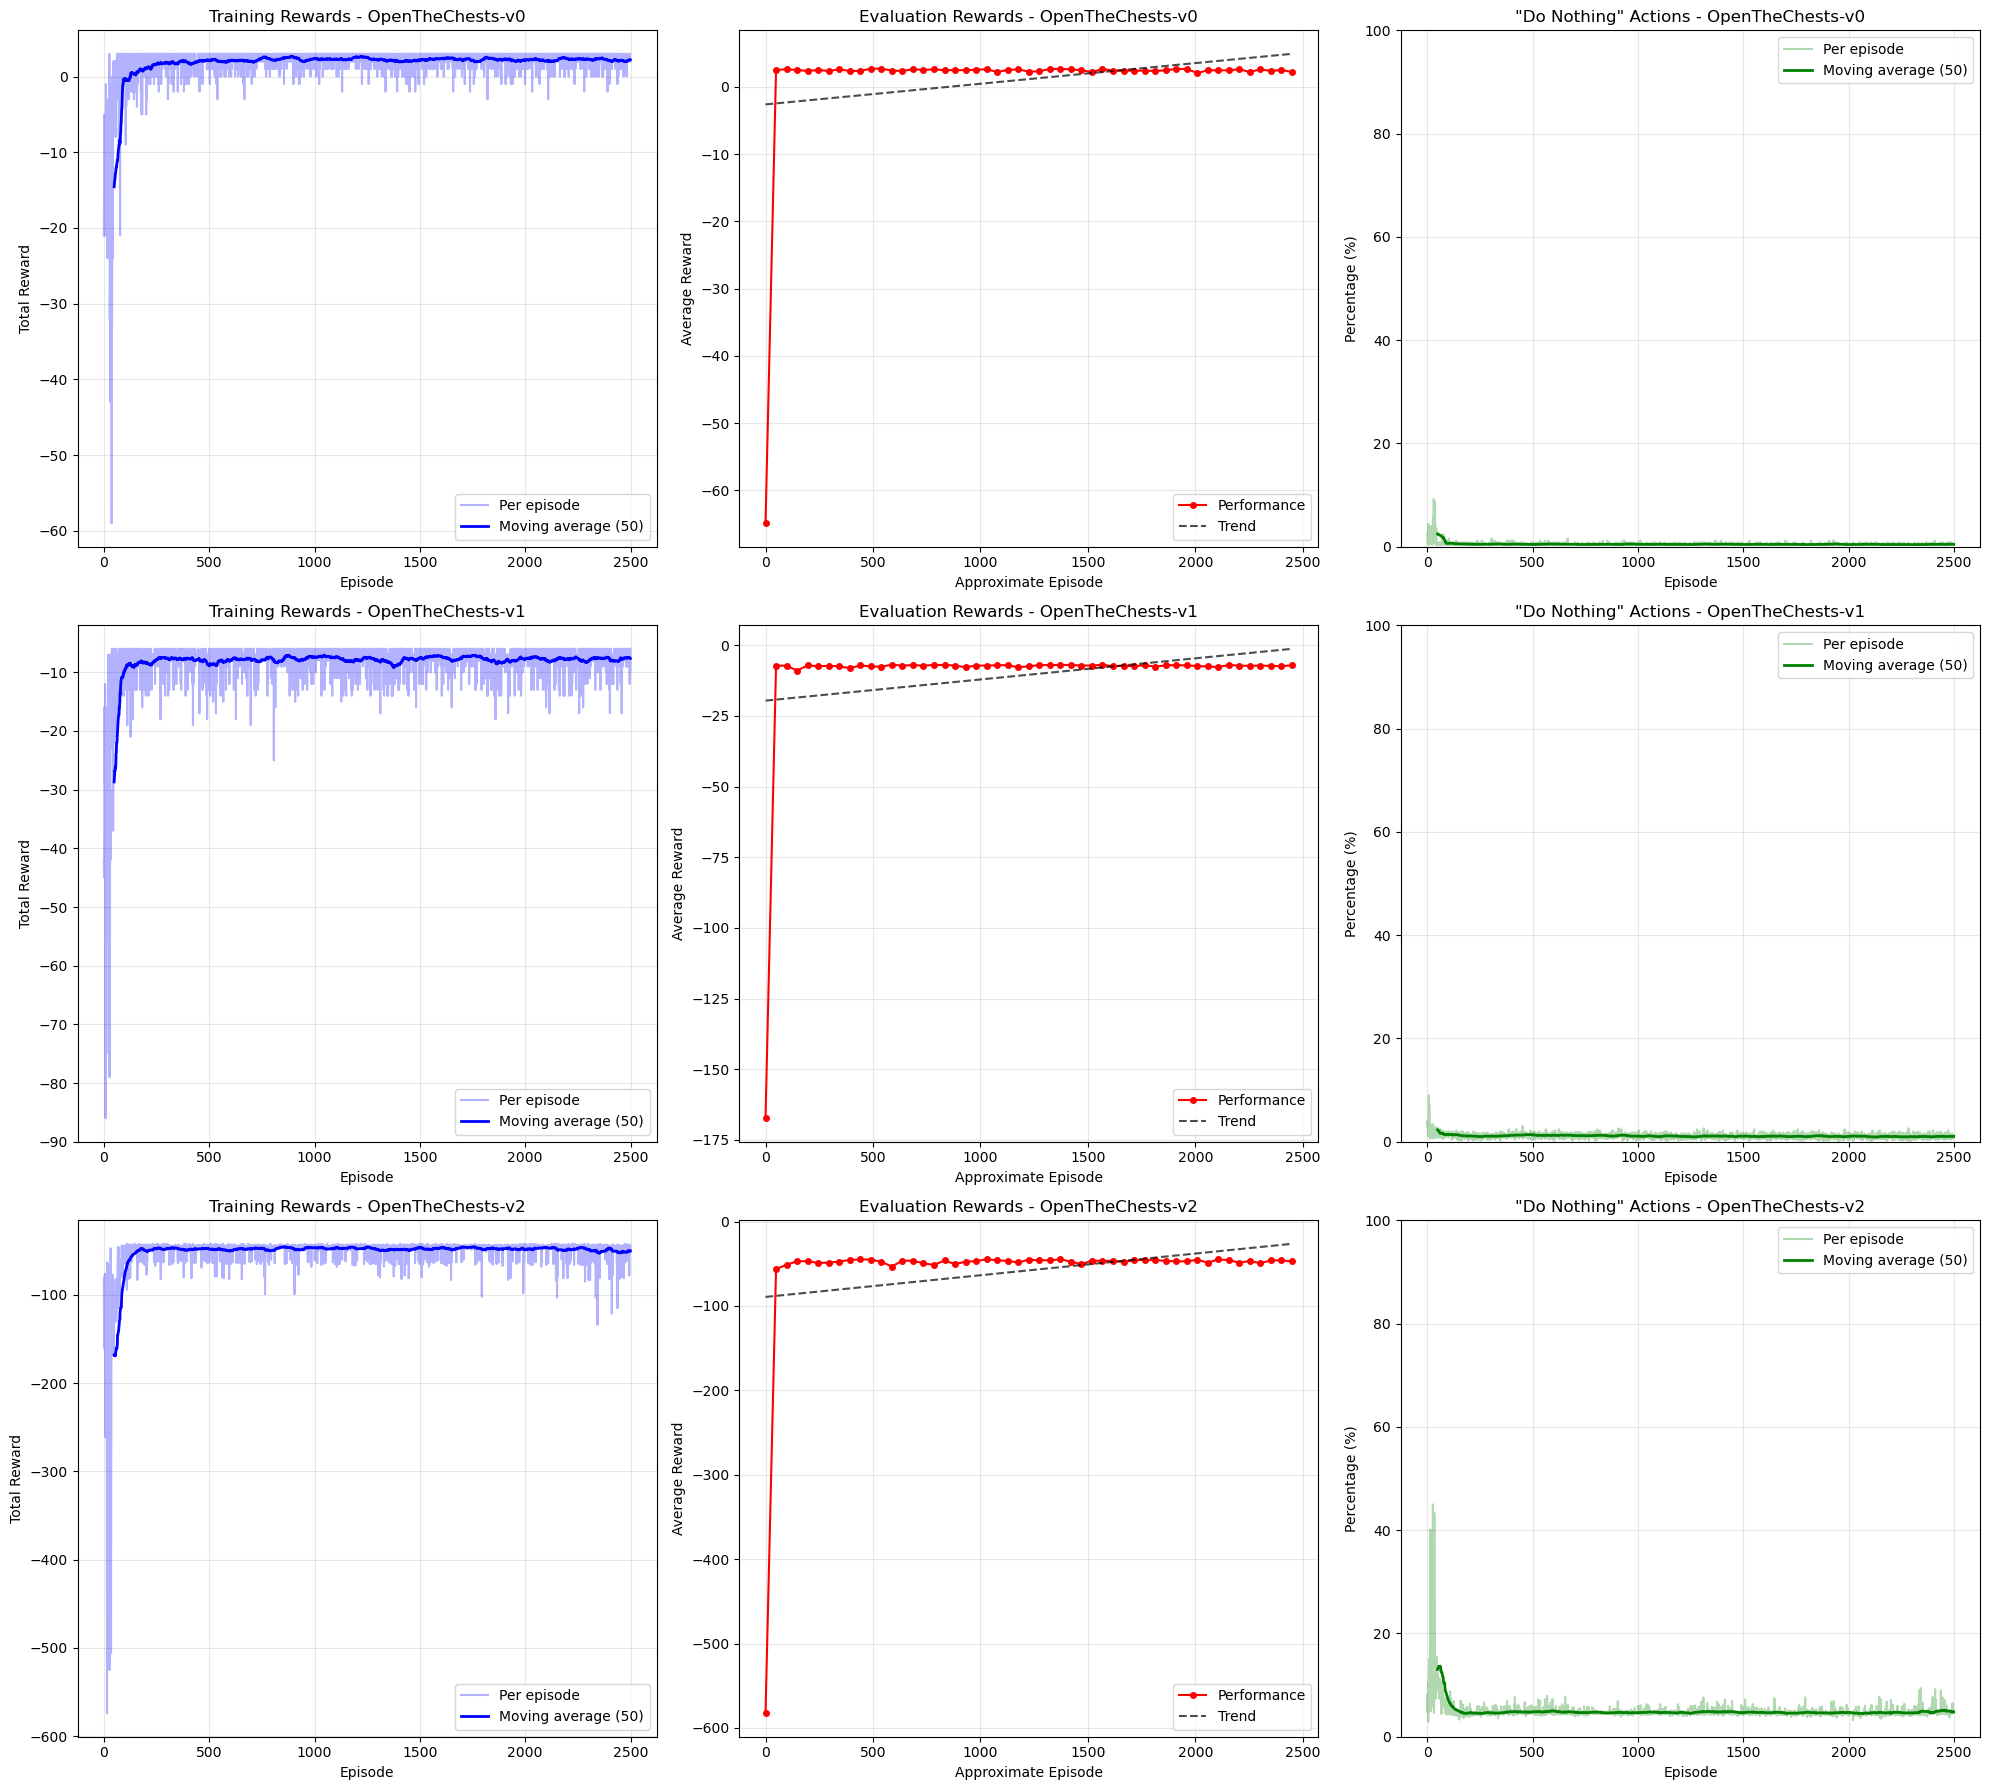


Combined evaluation plot saved as 'combined_evaluation_performance.png'


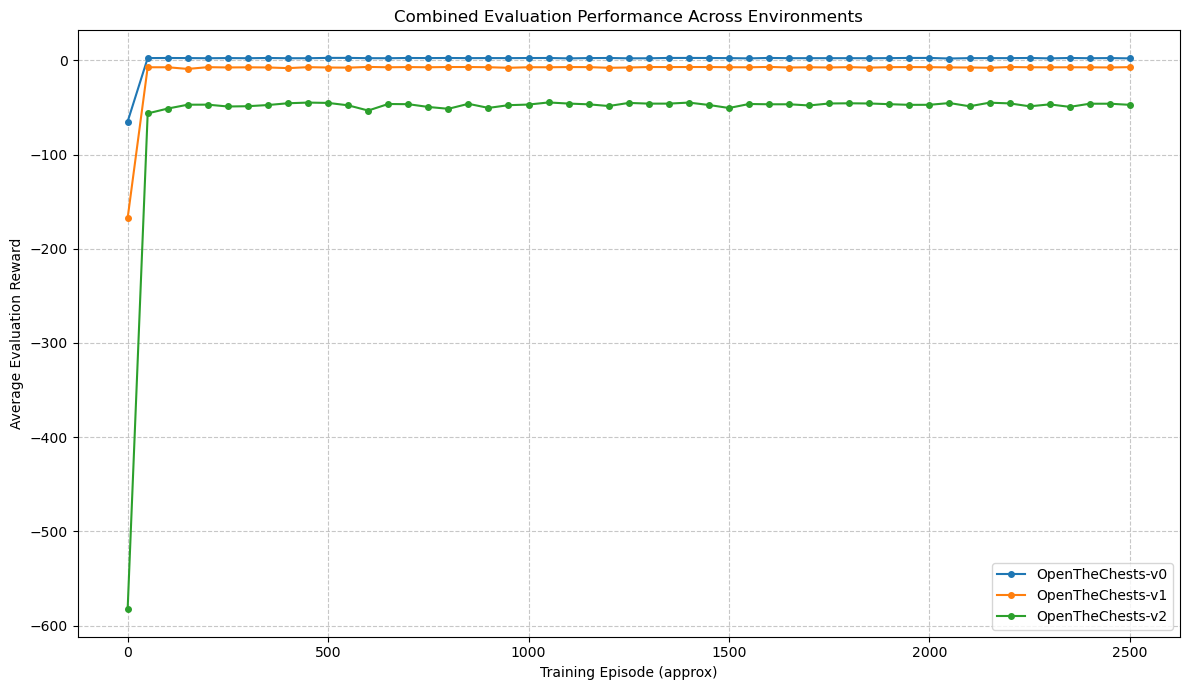


Final Results:
OpenTheChests-v0: Best=2.70, Final=2.20, Avg No-Action=1.0
OpenTheChests-v1: Best=-6.90, Final=-7.10, Avg No-Action=5.1
OpenTheChests-v2: Best=-44.60, Final=-47.15, Avg No-Action=50.4


In [8]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Train or load agents for all environment variants
    trained_agents = train_and_evaluate_all_environments(load_if_exists=False)

    print("\nFinal Results:")
    for agent in trained_agents:
        if agent.eval_rewards:
            best_reward = max(agent.eval_rewards)
            final_reward = agent.eval_rewards[-1]
            avg_no_action = np.mean(agent.no_action_counts[-10:])
            print(
                f"{agent.env_name}: Best={best_reward:.2f}, Final={final_reward:.2f}, Avg No-Action={avg_no_action:.1f}")

### Analysis of Reinforcement Learning Results for "Open the Chests" Environments

### OpenTheChests-v0 (Simple Environment)

**Performance Analysis:**

- **Quick Learning**: The agent rapidly improved from initial negative rewards (-21.0) to positive rewards (2.0) by episode 50
- **Stable Convergence**: Performance stabilized early, reaching near-optimal behavior around episode 100
- **High Final Performance**: Achieved a final evaluation score of 2.58 across 50 episodes
- **Best Score**: 2.70 at episode 500
- **Training Stability**: Very stable with consistent performance after initial learning

This matches expectations for v0, where a simple MLP can effectively learn the one-to-one mapping between events and actions. The agent quickly identified the correct action for each event signature.

### OpenTheChests-v1 (Medium Environment)

**Performance Analysis:**

- **Slower Learning**: Started much worse (-26.0 train, -166.0 eval) but improved significantly by episode 50
- **Gradual Improvement**: Performance gradually improved over the 2500 episodes
- **Negative but Stable Rewards**: Best reward was -6.55 at episode 2350
- **Consistent Behavior**: Episodes typically lasted 12-17 steps
- **Final Performance**: -7.36 evaluation reward across 50 episodes

The LSTM-based architecture successfully learned to track short event sequences but couldn't achieve positive rewards. This indicates the increased difficulty of recognizing patterns across 4-event sequences compared to the simple v0 environment.

### OpenTheChests-v2 (Complex Environment)

**Performance Analysis:**

- **Difficult Learning**: Started with very poor performance (-153.0 train, -583.2 eval)
- **Significant Initial Progress**: Major improvements by episode 100 (-45.0 train, -49.25 eval)
- **Training Instability**: Performance fluctuated more than other variants
- **Loss Pattern**: Loss initially decreased but later increased (from ~0.06 to ~0.76), suggesting potential overfitting
- **Long Episodes**: Typically 48-55 steps per episode
- **Best Performance**: -44.75 at episode 1650
- **Final Score**: -49.78 evaluation reward

The complex environment clearly challenged even the sophisticated LSTM+Transformer architecture. The learning curve showed periods of improvement followed by instability, particularly after episode 2500 where performance occasionally degraded significantly (e.g., -110.50 at episode 3000).

### Comparative Analysis

1. **Architecture-Environment Match**:

   - The results confirm that architectural complexity needs to match environmental complexity
   - Simple MLP was sufficient for v0, while v1 and v2 required more sophisticated networks

2. **Learning Efficiency**:

   - Learning speed decreased as environment complexity increased
   - v0: ~50 episodes to reach good performance
   - v1: ~500 episodes
   - v2: ~1650 episodes

3. **Reward Scaling**:

   - The magnitude of negative rewards corresponds to environment complexity
   - This reflects the increasing difficulty of identifying longer patterns

4. **Training Stability**:

   - Stability decreased with environment complexity
   - v2 showed significant variability in later episodes, suggesting challenges in maintaining consistent performance

5. **Hyperparameter Sensitivity**:
   - Lower learning rates were used for more complex environments
   - v2 required adaptive learning rate scheduling and more sophisticated optimization techniques


## AGENT 2: Execute Agent 1's Instruction

### 2.1. Context and Objective

The robot **Kuka IIWA** (7 DOF) must bring its **end-effector (EE)** within `success_eps` meters of a randomly selected target cube from several cubes placed on a virtual table. During the movement, the arm must:

- Avoid moving non-target cubes;
- Avoid collisions with the ground;
- Act energy-efficiently (action penalty).

The agent is trained using **PPO** (Stable Baselines 3). The simulation runs in **PyBullet**, and the environment follows the **Gymnasium** API to leverage standard wrappers (Monitor, VecNormalize, RecordVideo, etc.).

---

### 2.2. Code Anatomy (function by function)

#### 2.2.1 `KukaMultiCubeReachEnv`: core of the simulation

- **`__init__`**: general setup (number of cubes, placement radius, thresholds, physics substeps, etc.) and creation of action/observation spaces.
- **`_setup_simulation`**: opens PyBullet connection, loads the floor plane, Kuka URDF model, and prepares joint limits.
- **`_update_joint_limits`**: queries PyBullet for joint bounds, max velocities, and joint ranges, essential for velocity control.
- **`_define_observation_space`**: dynamically computes the observation space (24-feature size) based on actual limits.
- **`reset`**: resets the robot and (re)generates cubes; selects target cube based on `train` or `eval` mode. Can continue a session ("partial reset") if `continue_training_episodes=True`.
- **`_spawn_n_cubes`**: places up to _N_ cubes within a radial ring, utilizing an IK checker to ensure reachability before inserting them into physics.
- **`_is_pose_reachable`**: small inverse kinematics loop (max 50 iterations) to verify if a pose is feasible.
- **`_get_obs`** and **`_get_info`**: respectively construct the observation vector and a debugging info dictionary (distance to target, non-target movements, etc.).
- **`scale_action`**: transforms `[-1,1]` into physical joint velocities.
- **`step`**: applies the action, advances the simulation (`substeps`), updates the observation, computes the composite reward, and determines if `terminated` or `truncated`.
- **`check_collision`** and **`render`**: utility tools for penalties and visualization.
- **`close`**: cleanly releases the PyBullet connection and resets pointers.

#### 2.2.2 Environment Utilities

- **`create_env`**: creates a single instance, wraps it (Monitor, RecordVideo), and returns it. Also used to feed `DummyVecEnv` so `VecNormalize` functions even with a single environment.

#### 2.2.3 Training Phase

- **`train`**: orchestrates the full training:

  - instantiates and normalizes the vectorized environment;
  - loads an existing model or creates a fresh PPO applying hyperparameters;
  - logs to TensorBoard;
  - calls `model.learn()` with a `CheckpointCallback` to periodically save the model and normalization statistics.

#### 2.2.4 Inference/Demonstration Phase

- **`load_and_run`**: opens the environment in `human` mode, optionally reloads `VecNormalize` stats, then loops for `num_episodes` to demonstrate the learned behavior. The sub-vector environment "NoAutoResetDummy" enables retrieval of terminal observations without automatic resets, useful for debugging.

---

### 3. Reward and Learning Dynamics

The per-step reward is:

1. **Negative EE→target distance** to provide a dense gradient.
2. **Success bonus** `+10` when distance falls below `success_eps`.
3. **Improvement bonus** when the agent breaks its proximity record during the episode.
4. **Penalties**: movement or penetration near non-target cubes, collisions with ground/objects, action energy (`‖a‖²`), and a small time penalty.

These terms have been empirically calibrated: initially using only distance and success bonus to validate basics, then progressively adding penalties to discipline the trajectory.

---

### 2.4. Reading TensorBoard Curves

The four images illustrate a 10-million-step run:

- **`train/value_loss`**: rapid initial drop, stabilizing around 14. A too-high value (>25) would indicate the value function struggles to track the policy.

![value loss](imgs/value_loss.png)

- **`train/loss`** (policy + entropy): shows healthy oscillations reflecting PPO exploration. No upward drift means `clip_range` regularization is sufficient.

![policy loss](imgs/loss.png)

- **`rollout/ep_rew_mean`**: monotonic progression from -15 to about -3. Each plateau corresponds to the introduction of new penalties, complicating the task.

![mean reward](imgs/ep_rew_mean.png)

- **`rollout/ep_len_mean`**: initially short (agent quickly fails), then extends to about 6-7 substeps, indicating the agent takes more care to adjust its pose without colliding with obstacles.

![ep length](imgs/ep_len_mean.png)

Collectively, these graphs confirm that:

1. The **value function converges** without explosive divergence.
2. The **policy is truly learning** (mean reward increases) rather than exploiting reward bugs.
3. The **behavior becomes more cautious** (longer episodes)—consistent with action and collision penalties.

---

### 2.5. Future Improvement Directions

Currently, each episode starts from **a fixed joint pose** ("neutral pose"). This convention simplifies initial learning: the network always sees the same initial configuration, focusing on reaching the target cube.

For **continuous control "command→action"** (executing successive commands without physics reset), one should:

1. execute the current action;
2. return the arm to the neutral pose;
3. only then launch the next step.

> _Why?_
> The network doesn’t need to "understand" the full inverse kinematics from unknown states; instead, it learns a **local sub-policy** centered around the neutral pose. This reduces variance and speeds convergence but limits generality.

An attempt at training **with random initial poses** was made so the agent could reach targets from any configuration. Results remained disappointing: the policy struggled due to dense yet noisy rewards and a vastly larger initial state space.


In [9]:
"""
Environnement Gymnasium pour un robot Kuka IIWA devant atteindre un cube cible
parmi plusieurs, en utilisant PyBullet. Inclut des fonctions pour entraîner
un agent RL (Stable Baselines3) et charger un agent entraîné.
"""

import os
import time
import math
import random
from typing import Optional, Dict, Tuple, Any, List
from copy import deepcopy

import gymnasium as gym_
import numpy as np
import pybullet as p
import pybullet_data
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


# --- Environnement KukaMultiCubeReachEnv ---
class KukaMultiCubeReachEnv(gym_.Env):
    """
    Environnement Gymnasium simulant un Kuka IIWA pour une tâche de Reach multi-cubes.

    L'objectif est d'amener l'effecteur final du robot près d'un cube cible
    désigné aléatoirement parmi plusieurs cubes présents dans l'environnement,
    tout en évitant de déplacer les autres cubes ou de s'en approcher trop près.

    **Espace d'observation:** (détaillé dans __init__)
        - Positions des joints
        - Vitesses des joints
        - Position absolue du cube cible
        - Position relative EE -> cube cible
        - Vitesse linéaire de l'EE
        - Index normalisé du cube cible

    **Espace d'action:** (détaillé dans __init__)
        - Commande en vitesse pour chaque joint, normalisée dans [-1, 1].

    **Récompense:**
        - Négative proportionnelle à la distance EE-Cible.
        - Bonus élevé en cas de succès (distance < success_eps).
        - Bonus de shaping basé sur l'amélioration de la distance minimale atteinte.
        - Pénalité si un cube non-cible est déplacé.
        - Pénalité si l'EE entre dans la zone d'exclusion d'un cube non-cible.
        - Pénalité en cas de collision robot-sol.
        - Pénalité proportionnelle à la magnitude de l'action.
        - Petite pénalité de temps à chaque pas.

    **Terminaison (terminated):**
        - Succès (EE proche du cube cible).
        - Collision robot-sol.
        # (Optionnel, désactivé par défaut) Déplacement excessif d'un cube non-cible.
        # (Optionnel, désactivé par défaut) Violation zone d'exclusion non-cible.

    **Troncation (truncated):**
        - Nombre maximum de pas atteint (max_episode_steps).
    """
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self,
                 render_mode: Optional[str],
                 num_cubes: int,
                 cube_size: float,
                 r_min: float,
                 r_max: float,
                 max_episode_steps: int,
                 substeps: int,
                 success_eps: float,
                 ee_link_index: int,
                 joint_force: float,
                 cube_move_penalty_coeff: float,
                 cube_move_threshold: float,
                 non_target_zone_penalty_coeff: float,
                 non_target_zone_eps: float,
                 action_penalty_coeff: float,
                 max_ee_velocity: float,
                 min_dist_between_cubes: float,
                 continue_training_episodes: bool
                 ):
        super().__init__()
        self.render_mode = render_mode
        # 'renders' est déprécié au profit de render_mode, on garde juste render_mode
        self.is_rendering = self.render_mode in ["human", "rgb_array"]

        self.continue_training_episodes = continue_training_episodes

        # --- Paramètres spécifiques multi-cubes ---
        if num_cubes <= 0:
            raise ValueError("num_cubes doit être positif.")
        self.num_cubes = num_cubes
        self.min_dist_between_cubes = min_dist_between_cubes
        self.non_target_zone_eps = non_target_zone_eps
        self.non_target_zone_penalty_coeff = non_target_zone_penalty_coeff
        self.cube_move_penalty_coeff = cube_move_penalty_coeff
        self.cube_move_threshold = cube_move_threshold

        # --- Autres paramètres ---
        self.cube_size = cube_size
        self.r_min = r_min
        self.r_max = r_max
        self._max_episode_steps = max_episode_steps  # Renommé pour éviter conflit
        self.substeps = substeps
        self.success_eps = success_eps
        self.ee_link_index = ee_link_index
        self.joint_force = joint_force
        self.max_ee_velocity = max_ee_velocity
        self.action_penalty_coeff = action_penalty_coeff

        # Initialisation PyBullet (connexion différée à reset pour environnements vectorisés)
        self.physicsClient = None
        self.plane_id = None
        self.kuka_id = None
        self.timeStep = 1. / 240.

        # Option du Reset
        self._next_reset_options: Optional[Dict] = None

        # Propriétés du robot (initialisées après chargement)
        self.num_arm_joints = 7  # Pour Kuka IIWA typique
        self.max_joint_velocity = np.zeros(
            self.num_arm_joints, dtype=np.float32)
        self.joint_ranges = []
        self.joint_lower_limits = np.zeros(
            self.num_arm_joints, dtype=np.float32)
        self.joint_upper_limits = np.zeros(
            self.num_arm_joints, dtype=np.float32)

        # --- Espace d'action (contrôle en VITESSE) ---
        # L'action est toujours entre [-1, 1] par joint
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(self.num_arm_joints,), dtype=np.float32)

        # --- Espace d'observation ---
        # Sera défini précisément dans _setup_simulation basé sur les limites réelles
        obs_dim = self.num_arm_joints * 2 + 3 + 3 + 3 + 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # Variables d'état
        self.current_step = 0
        self.cube_ids: List[int] = []
        self.cube_ref_positions: List[np.ndarray] = []
        self.target_cube_index: int = -1
        self.best_distance = np.inf

        # id pour les cubes
        self.debug_text_ids = []

    def _setup_simulation(self):
        """Initialise la simulation PyBullet si elle ne l'est pas déjà."""
        if self.physicsClient is not None:
            return  # Déjà initialisé

        connection_mode = p.GUI if self.render_mode == "human" else p.DIRECT
        self.physicsClient = p.connect(connection_mode)
        if self.physicsClient < 0:
            raise RuntimeError("Impossible de se connecter à PyBullet.")

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        p.setTimeStep(self.timeStep)

        # Chargement des éléments
        self.plane_id = p.loadURDF("plane.urdf")
        # Note: Assurez-vous que le chemin vers kuka_iiwa est correct
        # ou que le modèle est dans un chemin recherché par pybullet_data
        try:
            self.kuka_id = p.loadURDF(
                "kuka_iiwa/model_vr_limits.urdf", [0., 0., 0.], [0, 0, 0, 1], useFixedBase=True)
        except p.error as e:
            print("\n" + "="*30 + " ERREUR " + "="*30)
            print("Impossible de charger 'kuka_iiwa/model_vr_limits.urdf'.")
            print("Assurez-vous que PyBullet peut trouver ce fichier.")
            print("Il est peut-être nécessaire d'installer des assets supplémentaires")
            print("ou de les placer dans un répertoire accessible.")
            print(f"Erreur PyBullet: {e}")
            print("="*68 + "\n")
            raise

        actual_num_joints = p.getNumJoints(self.kuka_id)
        if actual_num_joints != self.num_arm_joints:
            print(f"Avertissement: Le modèle Kuka chargé a {actual_num_joints} joints, "
                  f"mais {self.num_arm_joints} étaient attendus. Ajustement...")
            self.num_arm_joints = actual_num_joints
            # Redéfinir action_space et recalculer obs_dim si nécessaire
            self.action_space = spaces.Box(
                low=-1, high=1, shape=(self.num_arm_joints,), dtype=np.float32)

        if self.ee_link_index >= self.num_arm_joints:
            print(
                f"Avertissement: ee_link_index ({self.ee_link_index}) >= num_arm_joints ({self.num_arm_joints}). Utilisation du dernier indice de lien.")
            self.ee_link_index = self.num_arm_joints - 1

        # Récupérer les limites réelles des joints et définir l'espace d'observation
        self._update_joint_limits()
        self._define_observation_space()

    def _update_joint_limits(self):
        """ Récupère les limites des joints depuis le modèle chargé. """
        self.max_joint_velocity = []
        self.joint_ranges = []
        self.joint_lower_limits = []
        self.joint_upper_limits = []
        for i in range(self.num_arm_joints):
            joint_info = p.getJointInfo(self.kuka_id, i)
            # Indices: 8=lowerLimit, 9=upperLimit, 11=maxVelocity
            lower, upper = joint_info[8], joint_info[9]
            # Ignorer les joints fixes ou sans limites définies correctement
            if lower > upper:
                print(
                    f"Joint {i} ({joint_info[1]}) a des limites invalides ({lower}, {upper}). Utilisation de limites par défaut [0,0].")
                lower, upper = 0.0, 0.0
            self.joint_ranges.append((lower, upper))
            self.joint_lower_limits.append(lower)
            self.joint_upper_limits.append(upper)
            # S'assurer que maxVelocity est positif, sinon utiliser une valeur par défaut raisonnable
            max_vel = joint_info[11]
            if max_vel <= 0:
                # print(f"Joint {i} ({joint_info[1]}) a une maxVelocity <= 0 ({max_vel}). Utilisation de 2.0 rad/s.")
                max_vel = 2.0  # Valeur par défaut
            self.max_joint_velocity.append(max_vel)

        self.joint_lower_limits = np.array(
            self.joint_lower_limits, dtype=np.float32)
        self.joint_upper_limits = np.array(
            self.joint_upper_limits, dtype=np.float32)
        self.max_joint_velocity = np.array(
            self.max_joint_velocity, dtype=np.float32)

    def _define_observation_space(self):
        """ Définit l'espace d'observation basé sur les limites des joints. """
        # pos joints + vel joints + pos CUBE CIBLE + pos relative EE->CIBLE + vel EE + index CIBLE (normalisé)
        obs_dim = self.num_arm_joints * 2 + 3 + 3 + 3 + 1
        distance_max = self.r_max + 1
        low_obs = np.concatenate([
            self.joint_lower_limits,                        # joint pos
            # joint velocities (estimation large)
            -self.max_joint_velocity * 2,
            # target cube position x,y,z
            -distance_max * np.ones(3) * 1.5,
            # relative EE→target x,y,z
            -2 * distance_max * np.ones(3) * 1.5,
            # EE velocity vx,vy,vz
            -self.max_ee_velocity * np.ones(3) * 1.5,
            # target cube index (normalisé)
            [0.0]
        ])
        high_obs = np.concatenate([
            self.joint_upper_limits,
            self.max_joint_velocity * 2,
            distance_max * np.ones(3) * 1.5,
            2 * distance_max * np.ones(3) * 1.5,
            self.max_ee_velocity * np.ones(3) * 1.5,
            [1.0]  # Normalisé entre 0 et 1 (si num_cubes > 1)
        ])
        self.observation_space = spaces.Box(low=low_obs,
                                            high=high_obs,
                                            shape=(obs_dim,),
                                            dtype=np.float32)

    def set_next_reset_options(self, options: Dict):
        """
        Stocke les options qui seront utilisées lors du prochain appel à reset().
        Ceci est utilisé pour passer des options à travers les wrappers VecEnv.
        """
        # print(f"DEBUG: Setting next reset options: {options}") # Debug
        self._next_reset_options = options

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        """
        Réinitialise l'environnement à un état initial.

        Args:
            seed: Graine pour la génération de nombres aléatoires.
            options: Dictionnaire optionnel pouvant contenir :
                - 'mode' (str): 'train' (défaut) ou 'eval'.
                - 'target_index' (int): Si mode='eval', spécifie l'index du cube cible.
                - 'start_from_previous_state' (bool): Si True (et pas le premier reset),
                ne réinitialise pas la position du robot ni les cubes,
                change seulement la cible et met à jour les positions de référence.
                Défaut à False (reset complet).


        Returns:
            Tuple contenant l'observation initiale et le dictionnaire d'info.
        """
        super().reset(seed=seed)

        # Utiliser les options stockées si disponibles, sinon celles passées en argument
        options = self._next_reset_options if self._next_reset_options is not None else options
        if options is None:
            options = {}  # Assurer que c'est un dictionnaire

        # Réinitialiser les options stockées après les avoir lues
        self._next_reset_options = None

        # Déterminer le mode (défaut 'train')
        if options is None:
            options = {}
        mode = options.get('mode', 'train')

        # options.get('start_from_previous_state', False)
        start_from_previous_state = self.continue_training_episodes

        # Initialiser la simulation PyBullet si ce n'est pas déjà fait
        self._setup_simulation()

        # On vérifie si self.cube_ids a été initialisé et n'est pas vide.
        is_first_reset = not hasattr(self, 'cube_ids') or not self.cube_ids
        # print('start_from_previous_state',start_from_previous_state)

        if not start_from_previous_state or is_first_reset:
            # --- Reset du robot ---
            # Utiliser les limites récupérées pour la position initiale
            initial_joint_positions = (
                self.joint_lower_limits + self.joint_upper_limits) / 2.0
            for i in range(self.num_arm_joints):

                # initial_joint_positions =  random.uniform(self.joint_lower_limits[i], self.joint_upper_limits[i])
                # p.resetJointState(self.kuka_id, i, targetValue=initial_joint_positions, targetVelocity=0.0)
                p.resetJointState(
                    self.kuka_id, i, targetValue=initial_joint_positions[i], targetVelocity=0.0)
                # Désactiver le moteur au cas où il serait actif (pour éviter forces résiduelles)
                p.setJointMotorControl2(
                    self.kuka_id, i, p.VELOCITY_CONTROL, force=0)

            # --- Suppression des anciens cubes ---
            for cube_id in self.cube_ids:
                try:
                    p.removeBody(cube_id)
                except p.error:
                    pass
            self.cube_ids = []
            self.cube_ref_positions = []
            self.target_cube_index = -1
            self._current_num_cubes_spawned = 0

            # --- Spawn de N nouveaux cubes ---
            spawn_successful = False
            max_reset_trials = 20
            for _ in range(max_reset_trials):
                if self._spawn_n_cubes(self.num_cubes, self.r_min, self.r_max, self.cube_size, self.min_dist_between_cubes):
                    spawn_successful = True
                    # Stocker le nombre réel de cubes spawnés
                    self._current_num_cubes_spawned = len(self.cube_ids)
                    break
                else:
                    # Nettoyer avant nouvelle tentative
                    for cube_id in self.cube_ids:
                        try:
                            p.removeBody(cube_id)
                        except p.error:
                            pass
                    self.cube_ids = []
                    self.cube_ref_positions = []

            if not spawn_successful or self._current_num_cubes_spawned == 0:
                raise RuntimeError(
                    f"Impossible de spawner au moins 1 cube atteignable après {max_reset_trials} tentatives.")

                # --- Enregistrer les positions initiales de TOUS les cubes spawnés ---

            self.cube_ref_positions = []
            for cube_id in self.cube_ids:
                try:
                    pos, _ = p.getBasePositionAndOrientation(cube_id)
                    self.cube_ref_positions.append(np.array(pos))
                except p.error as e:
                    print(
                        f"Erreur PyBullet en récupérant la position initiale du cube {cube_id}: {e}")
                    self.cube_ref_positions.append(np.zeros(3))

        self.current_step = 0
        self.best_distance = np.inf
        # --- Choix du cube cible selon le mode ---
        if mode == 'eval':
            if 'target_index' not in options:
                raise ValueError(
                    "Le mode 'eval' nécessite 'target_index' dans les options de reset.")
            target_index_req = options['target_index']
            if not isinstance(target_index_req, int) or not (0 <= target_index_req < self._current_num_cubes_spawned):
                raise ValueError(f"Index cible invalide ({target_index_req}) fourni en mode 'eval'. "
                                 f"Doit être entre 0 et {self._current_num_cubes_spawned - 1}.")
            self.target_cube_index = target_index_req
            print(
                f"[Eval Mode] Target cube index set to: {self.target_cube_index}")

        elif mode == 'train':
            # Choix aléatoire parmi les cubes spawnés
            self.target_cube_index = self.np_random.integers(
                0, self._current_num_cubes_spawned)
            # print(f"[Train Mode] Random target cube index: {self.target_cube_index}")
        else:
            raise ValueError(
                f"Mode inconnu '{mode}' reçu dans les options de reset. Utiliser 'train' ou 'eval'.")

        # ——— Affichage de l’indice du cube ciblé ———
        target_id = self.cube_ids[self.target_cube_index]
        # On récupère sa position pour placer le texte un peu au-dessus
        pos, _ = p.getBasePositionAndOrientation(target_id)
        text_pos = [pos[0], pos[1], pos[2] + self.cube_size * 3]
        # On balance le texte “TARGET i” en blanc et taille 2, attaché au cube
        txt_id = p.addUserDebugText(
            text=f"TARGET {self.target_cube_index}",
            textPosition=text_pos,
            textColorRGB=[0, 0, 0],
            textSize=1.0,
            parentObjectUniqueId=target_id,
            parentLinkIndex=-1,
            lifeTime=0
        )
        # On garde cet ID pour pouvoir le nettoyer plus tard
        self.debug_text_ids.append(txt_id)
        # ————————————————————————————————

        # --- NOUVEAU / MODIFICATION: Mettre à jour les positions de référence SEULEMENT si on continue ---
        if start_from_previous_state and not is_first_reset:
            # print("DEBUG: Updating reference positions to current cube positions.") # Pour Debug
            new_ref_positions = []
            for cube_id in self.cube_ids:
                try:
                    pos, _ = p.getBasePositionAndOrientation(cube_id)
                    new_ref_positions.append(np.array(pos))
                except p.error as e:
                    print(
                        f"Erreur PyBullet getBasePositionAndOrientation pour ref cube {cube_id}: {e}")
                    # Tentative de fallback vers l'ancienne position si possible
                    try:
                        old_index = self.cube_ids.index(
                            cube_id)  # Récupérer l'index actuel
                        # Vérifier si une ancienne ref existe
                        if old_index < len(self.cube_ref_positions):
                            print(
                                f"    -> Conservation de l'ancienne position de référence pour le cube {cube_id}")
                            new_ref_positions.append(
                                self.cube_ref_positions[old_index])
                        else:
                            print(
                                f"    -> Position de référence non trouvée pour le cube {cube_id}, utilisation de [0,0,0].")
                            new_ref_positions.append(np.zeros(3))  # Fallback
                    except (ValueError, IndexError):  # Si index non trouvé ou hors limites
                        print(
                            f"    -> Fallback: Utilisation de [0,0,0] comme référence pour le cube {cube_id}.")
                        new_ref_positions.append(
                            np.zeros(3))  # Fallback ultime

            # Mettre à jour avec les positions actuelles
            self.cube_ref_positions = new_ref_positions

        # Stabilisation (quelques pas de simulation sans action)
        for _ in range(50):
            p.stepSimulation()

        observation = self._get_obs()
        info = self._get_info()
        if "distance_to_target" in info:
            self.best_distance = info["distance_to_target"]
        else:
            self.best_distance = np.inf

        # Ajouter le mode et l'index cible à l'info retournée
        info['reset_mode'] = mode
        info['target_cube_index'] = self.target_cube_index
        info['partial_reset'] = start_from_previous_state and not is_first_reset

        # print(f"--- RESET FINISHED  ---")
        return observation, info

    def scale_action(self, action: np.ndarray) -> np.ndarray:
        """Met à l'échelle l'action de [-1, 1] vers les vitesses cibles des joints."""
        return action * self.max_joint_velocity

    def _is_pose_reachable(self, target_pos, target_orn=None) -> bool:
        """ Vérifie si une pose est atteignable par cinématique inverse. """
        # Vérifier que les limites sont définies
        if not hasattr(self, 'joint_lower_limits') or len(self.joint_lower_limits) == 0:
            print("Avertissement: Limites de joints non définies pour IK.")
            return False

        # Définir une orientation par défaut (EE vers le bas) si non fournie
        if target_orn is None:
            target_orn = p.getQuaternionFromEuler(
                [0, -math.pi, 0])  # Pointant vers le bas

        # S'assurer que les limites sont passées en listes
        lower_limits = self.joint_lower_limits.tolist()
        upper_limits = self.joint_upper_limits.tolist()
        joint_range_val = (self.joint_upper_limits -
                           self.joint_lower_limits).tolist()
        rest_poses = ((self.joint_lower_limits +
                      self.joint_upper_limits) / 2.0).tolist()

        try:
            ik_solution = p.calculateInverseKinematics(
                self.kuka_id, self.ee_link_index, target_pos, targetOrientation=target_orn,
                lowerLimits=lower_limits,
                upperLimits=upper_limits,
                jointRanges=joint_range_val,
                restPoses=rest_poses,
                maxNumIterations=50,  # Augmenter un peu si nécessaire
                residualThreshold=1e-4  # Seuil acceptable pour la solution
            )
            # Vérifier si une solution a été retournée et si elle est valide (pas None et longueur correcte)
            return ik_solution is not None and len(ik_solution) == self.num_arm_joints

        except Exception as e:
            # print(f"Erreur IK pour {target_pos}: {e}") # Debug
            return False

        self.debug_text_ids = []  # Initialiser la liste pour les IDs de texte

    def _cleanup_items(self):
        """Nettoie les cubes et textes de débogage existants."""
        # Supprimer les textes de débogage
        for text_id in self.debug_text_ids:
            try:
                p.removeUserDebugItem(text_id)
            except p.error:
                pass  # Ignorer si déjà supprimé
        self.debug_text_ids = []  # Vider la liste

        # Supprimer les cubes
        for cube_id in self.cube_ids:
            try:
                p.removeBody(cube_id)
            except p.error:
                pass  # Ignorer si déjà supprimé
        self.cube_ids = []  # Vider la liste

    def _spawn_n_cubes(
        self,
        n: int,
        r_min: float,
        r_max: float,
        size: float,
        min_dist_between: float,
        height_offset: float = 0.0,
        max_trials_per_cube: int = 100
    ) -> bool:
        """
        Tente de faire apparaître N cubes atteignables, colorés, étiquetés et suffisamment espacés.
        Retourne True si succès, False sinon. Remplit self.cube_ids et self.debug_text_ids.
        """
        # --- Nettoyage préalable ---
        self._cleanup_items()  # Supprime les anciens cubes et textes avant d'en créer de nouveaux

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        default_edge = 0.05  # Taille du cube dans cube_small.urdf
        scale = size / default_edge if default_edge > 0 else 1.0
        spawned_positions = []
        # Utiliser des listes temporaires pour cette tentative de spawn
        current_cube_ids = []
        current_debug_text_ids = []

        # --- Définir une liste de couleurs distinctes (RGBA) ---
        # Vous pouvez étendre cette liste ou la générer dynamiquement
        colors = [
            [1, 0, 0, 1],  # Rouge
            [0, 1, 0, 1],  # Vert
            [0, 0, 1, 1],  # Bleu
            [1, 1, 0, 1],  # Jaune
            [1, 0, 1, 1],  # Magenta
            [0, 1, 1, 1],  # Cyan
            [1, 0.5, 0, 1],  # Orange
            [0.5, 0, 0.5, 1],  # Violet
            [0.5, 0.5, 0.5, 1]  # Gris
        ]

        for i in range(n):  # Pour chaque cube à spawner
            cube_placed = False
            for trial in range(max_trials_per_cube):
                # Échantillonnage (utiliser self.np_random si disponible, sinon np.random)
                # Utilise self.np_random s'il existe
                rng = getattr(self, 'np_random', np.random)
                radius = rng.uniform(r_min, r_max)

                # Côté gauche seulement
                theta = rng.uniform(np.pi / 2, 3 * np.pi / 2)

                x, y = radius * np.cos(theta), radius * np.sin(theta)
                z = height_offset + size / 2.0
                pos = np.array([x, y, z])

                # 1. Vérifier l'atteignabilité (avec orientation par défaut)
                # Note: L'orientation par défaut est [0,0,0,1] (quaternion)
                default_orientation = p.getQuaternionFromEuler([0, 0, 0])
                if not self._is_pose_reachable(pos, default_orientation):
                    # print(f"Position {pos} non atteignable.") # Debug
                    continue  # Essayer une autre position

                # 2. Vérifier la distance aux cubes déjà placés
                too_close = False
                for existing_pos in spawned_positions:
                    if np.linalg.norm(pos - existing_pos) < min_dist_between:
                        too_close = True
                        break
                if too_close:
                    # print(f"Position {pos} trop proche d'un autre cube.") # Debug
                    continue  # Essayer une autre position

                # Si la position est valide
                try:
                    orientation = p.getQuaternionFromEuler([0, 0, 0])
                    cube_id = p.loadURDF(
                        "cube_small.urdf",
                        basePosition=pos.tolist(),
                        baseOrientation=orientation,
                        globalScaling=scale,
                        useFixedBase=False  # ou True selon vos besoins
                    )

                    # --- MODIFICATION : Appliquer la couleur ---
                    # Choisir une couleur de la liste (en boucle si n > len(colors))
                    color_index = i % len(colors)
                    p.changeVisualShape(
                        objectUniqueId=cube_id,
                        linkIndex=-1,  # -1 pour la base de l'objet non articulé
                        rgbaColor=colors[color_index]
                    )

                    # --- MODIFICATION : Ajouter le texte (ID) ---
                    # Ou f"ID: {cube_id}" si vous préférez
                    text_label = f"Cube {i}"
                    # Position relative au centre du cube (légèrement au-dessus)
                    text_position_offset = [0, 0, size * 0.6]
                    text_color = [0, 0, 0]  # Couleur du texte (noir)
                    text_size = 1.5  # Taille du texte (à ajuster)

                    # Ajoute le texte attaché au cube
                    text_id = p.addUserDebugText(
                        text=text_label,
                        # Position relative si parentObjectUniqueId est défini
                        textPosition=text_position_offset,
                        textColorRGB=text_color,
                        textSize=text_size,
                        parentObjectUniqueId=cube_id,  # Attache le texte au cube
                        parentLinkIndex=-1,          # Attaché à la base du cube
                        lifeTime=0                   # 0 signifie que le texte persiste
                    )

                    # Ajouter aux listes temporaires
                    current_cube_ids.append(cube_id)
                    current_debug_text_ids.append(
                        text_id)  # Stocker l'ID du texte
                    spawned_positions.append(pos)
                    cube_placed = True
                    # print(f"Cube {i} placé à {pos} avec couleur {colors[color_index]}.") # Debug
                    break  # Passer au cube suivant

                except p.error as e:
                    # print(f"Erreur Pybullet lors du chargement du cube ({i+1}/{n}, essai {trial+1}): {e}")
                    # Si le chargement échoue, s'assurer qu'aucun corps partiel n'est laissé (normalement géré par PyBullet)
                    continue

            if not cube_placed:
                # print(f"Impossible de placer le cube {i + 1} après {max_trials_per_cube} essais.")
                # Nettoyer les cubes ET les textes déjà créés pour CETTE tentative de reset
                for tid in current_debug_text_ids:
                    try:
                        p.removeUserDebugItem(tid)
                    except p.error:
                        pass
                for cid in current_cube_ids:
                    try:
                        p.removeBody(cid)
                    except p.error:
                        pass
                # Vider les listes temporaires car l'opération a échoué
                current_cube_ids = []
                current_debug_text_ids = []
                spawned_positions = []
                # Assigner les listes vides aux membres de la classe pour refléter l'échec
                self.cube_ids = []
                self.debug_text_ids = []
                return False  # Échec du spawn de tous les cubes

        # Si tout s'est bien passé, assigner les listes temporaires aux variables membres
        self.cube_ids = current_cube_ids
        self.debug_text_ids = current_debug_text_ids
        # print(f"Spawn réussi de {n} cubes.") # Debug
        return True

    def _get_obs(self) -> np.ndarray:
        """Récupère l'observation actuelle basée sur le cube CIBLE."""
        # Vérifier si l'environnement est prêt
        if self.kuka_id is None or self.target_cube_index < 0 or self.target_cube_index >= len(self.cube_ids):
            print(
                "Avertissement: _get_obs appelé avant initialisation complète ou avec index cible invalide.")
            # Retourner une observation nulle de la bonne taille
            return np.zeros(self.observation_space.shape, dtype=self.observation_space.dtype)

        try:
            # États des joints
            joint_states = p.getJointStates(
                self.kuka_id, range(self.num_arm_joints))
            joint_pos = np.array([state[0]
                                 for state in joint_states], dtype=np.float32)
            joint_vel = np.array([state[1]
                                 for state in joint_states], dtype=np.float32)

            # État de l'effecteur final (EE)
            ee_state = p.getLinkState(
                self.kuka_id, self.ee_link_index, computeForwardKinematics=True, computeLinkVelocity=1)
            ee_pos = np.array(ee_state[0], dtype=np.float32)
            # Vitesse linéaire
            ee_vel = np.array(ee_state[6], dtype=np.float32)

            # Position du cube CIBLE
            target_cube_id = self.cube_ids[self.target_cube_index]
            target_cube_pos, _ = p.getBasePositionAndOrientation(
                target_cube_id)
            target_cube_pos = np.array(target_cube_pos, dtype=np.float32)

            # Position relative EE -> CIBLE
            relative_pos_to_target = target_cube_pos - ee_pos

            # Index du cube cible (normalisé entre 0 et 1 si num_cubes > 1)
            norm_target_index = 0.0
            if self.num_cubes > 1:
                norm_target_index = float(
                    self.target_cube_index) / (self.num_cubes - 1)

            # Concaténation de l'observation
            obs = np.concatenate([
                joint_pos, joint_vel,
                target_cube_pos, relative_pos_to_target, ee_vel,
                np.array([norm_target_index], dtype=np.float32)
            ])

            # Vérifier si l'observation correspond à l'espace défini
            if not self.observation_space.contains(obs):
                # Cliper ou juste avertir ? Cliper est souvent plus sûr pour SB3.
                # print("Avertissement: Observation en dehors des limites définies. Clipping.")
                obs = np.clip(obs, self.observation_space.low,
                              self.observation_space.high)

            # Assurer le bon type
            return obs.astype(self.observation_space.dtype)

        except p.error as e:
            print(
                f"Erreur PyBullet dans _get_obs: {e}. Retour d'une observation nulle.")
            return np.zeros(self.observation_space.shape, dtype=self.observation_space.dtype)
        except IndexError as e:
            print(
                f"Erreur d'index dans _get_obs (probablement lié à target_cube_index): {e}. Retour d'une obs nulle.")
            return np.zeros(self.observation_space.shape, dtype=self.observation_space.dtype)

    def _get_info(self) -> Dict[str, Any]:
        """Récupère des informations de débogage/analyse."""
        # Vérifier si l'environnement est prêt
        if self.kuka_id is None or self.target_cube_index < 0 or self.target_cube_index >= len(self.cube_ids):
            return {"status": "invalid_state", "message": "Info non disponible avant reset ou index cible invalide."}

        info = {
            "distance_to_target": np.inf,
            "target_cube_pos": np.zeros(3),
            "target_cube_index": self.target_cube_index,
            "ee_pos": np.zeros(3),
            "ee_vel": np.zeros(3),
            "non_target_distances": [],
            "non_target_displacements": [],
            "num_cubes": self.num_cubes,
            "status": "ok"  # Statut par défaut
        }

        try:
            # EE state
            ee_state = p.getLinkState(
                self.kuka_id, self.ee_link_index, computeForwardKinematics=True, computeLinkVelocity=1)
            ee_pos = np.array(ee_state[0])
            ee_vel = np.array(ee_state[6])
            info["ee_pos"] = ee_pos
            info["ee_vel"] = ee_vel

            # Target cube state
            target_cube_id = self.cube_ids[self.target_cube_index]
            target_cube_pos, _ = p.getBasePositionAndOrientation(
                target_cube_id)
            target_cube_pos = np.array(target_cube_pos)
            info["target_cube_pos"] = target_cube_pos

            distance_to_target = np.linalg.norm(target_cube_pos - ee_pos)
            info["distance_to_target"] = distance_to_target

            # Infos sur les cubes non-cibles
            for i, cube_id in enumerate(self.cube_ids):
                if i == self.target_cube_index:
                    continue
                # Vérifier que l'index i est valide pour cube_ref_positions
                if i >= len(self.cube_ref_positions):
                    print(
                        f"Avertissement: Index {i} hors limites pour cube_ref_positions dans _get_info.")
                    continue

                nt_pos, _ = p.getBasePositionAndOrientation(cube_id)
                nt_pos = np.array(nt_pos)
                info["non_target_distances"].append(
                    np.linalg.norm(ee_pos - nt_pos))

                # Comparer à la position de référence
                ref_pos = self.cube_ref_positions[i]
                displacement = np.linalg.norm(nt_pos - ref_pos)
                info["non_target_displacements"].append(displacement)

        except p.error as e:
            info["status"] = "pybullet_error"
            info["message"] = f"Erreur PyBullet dans _get_info: {e}"
            # Réinitialiser les valeurs potentiellement partielles
            info["distance_to_target"] = np.inf
            info["non_target_distances"] = []
            info["non_target_displacements"] = []
        except IndexError as e:
            info["status"] = "index_error"
            info["message"] = f"Erreur d'index dans _get_info: {e}"
            info["distance_to_target"] = np.inf
            info["non_target_distances"] = []
            info["non_target_displacements"] = []

        return info

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """ Exécute une étape dans l'environnement. """
        self.current_step += 1

        terminated = False
        truncated = False
        reward = 0.0

        try:
            # 1. Appliquer l'action (contrôle en vitesse)
            clipped_action = np.clip(
                action, self.action_space.low, self.action_space.high)
            target_joint_velocities = self.scale_action(clipped_action)

            p.setJointMotorControlArray(
                bodyUniqueId=self.kuka_id,
                jointIndices=range(self.num_arm_joints),
                controlMode=p.VELOCITY_CONTROL,
                targetVelocities=target_joint_velocities,
                forces=[self.joint_force] * self.num_arm_joints
            )

            # 2. Simulation PyBullet
            for _ in range(self.substeps):
                p.stepSimulation()
                if self.render_mode == 'human':
                    time.sleep(self.timeStep)

            # 3. Observation et Informations
            observation = self._get_obs()
            info = self._get_info()

            # --- Calcul de la récompense ---
            distance = info["distance_to_target"]
            ee_pos = info["ee_pos"]  # Assuré d'être valide si status=="ok"

            # Pénalité de distance au CUBE CIBLE (dense)
            # Utiliser une fonction qui ne devient pas trop négative (ex: exp(-dist))
            # reward -= distance # Simple pénalité linéaire
            reward = -distance  # Initialisation simple

            # Bonus de succès si assez proche du CUBE CIBLE
            if distance < self.success_eps:
                reward += 10.0  # Gros bonus pour succès
                terminated = True
                info["is_success"] = True  # Ajouter une info pour le Monitor
                # print(f"SUCCES! Cible {self.target_cube_index} atteinte step {self.current_step}")

            # Shaping "best-so-far" pour le CUBE CIBLE
            IMPROVE_BONUS_FACTOR = 1.0  # Ajuster ce facteur
            if distance < self.best_distance - 1e-5:  # Seuil pour éviter bruit numérique
                improvement = self.best_distance - distance
                # Bonus proportionnel à l'amélioration
                reward += IMPROVE_BONUS_FACTOR * improvement
                self.best_distance = distance

            # --- Pénalités liées aux CUBES NON-CIBLES ---
            total_non_target_move_penalty = 0.0
            total_non_target_zone_penalty = 0.0

            if self.num_cubes > 1:
                # Utiliser les infos pré-calculées si disponibles
                non_target_displacements = info.get(
                    "non_target_displacements", [])
                non_target_distances = info.get("non_target_distances", [])

                # Pénalité pour déplacement
                for displacement in non_target_displacements:
                    if displacement > self.cube_move_threshold:
                        # Pénalité qui augmente avec le déplacement
                        move_penalty = self.cube_move_penalty_coeff * \
                            (displacement - self.cube_move_threshold)
                        total_non_target_move_penalty += move_penalty

                # Pénalité pour violation de zone
                for dist_ee_to_nt in non_target_distances:
                    if dist_ee_to_nt < self.non_target_zone_eps:
                        # Pénalité proportionnelle à la pénétration
                        penetration = self.non_target_zone_eps - dist_ee_to_nt
                        zone_penalty = self.non_target_zone_penalty_coeff * penetration
                        total_non_target_zone_penalty += zone_penalty

            reward -= total_non_target_move_penalty
            reward -= total_non_target_zone_penalty

            # Pénalité de collision Robot <-> Sol
            if self.plane_id is not None and self.check_collision(self.kuka_id, self.plane_id):
                reward -= 10.0  # Pénalité fixe importante
                # terminated = True
                # info["collision_ground"] = True

            # Pénalité de collision Robot <-> cubes
            for cube_id in self.cube_ids:
                if self.check_collision(self.kuka_id, cube_id):
                    reward -= 1.0  # Pénalité fixe importante

            # Pénalité sur la magnitude de l'action
            if self.action_penalty_coeff > 0:
                action_magnitude_penalty = self.action_penalty_coeff * \
                    np.mean(np.square(clipped_action)
                            )  # Moyenne plutôt que somme
                reward -= action_magnitude_penalty

            # 4. Vérification de fin d'épisode (temps écoulé)
            if self.current_step >= self._max_episode_steps:
                truncated = True  # Fin normale par limite de temps

            # Assurer que terminated et truncated ne sont pas True en même temps (convention Gym)
            if terminated:
                truncated = False

            # Ajouter la récompense totale à l'info pour Monitor
            # info["reward"] = reward
            # if terminated: info.setdefault("is_success", False) # Assurer que is_success existe si terminé
            info["reward"] = reward
            info["is_success"] = info.get("is_success", False)

            # Le rendu est géré par la boucle externe
            # if self.render_mode == "human": self.render()

            return observation, reward, terminated, truncated, info

        except p.error as e:
            print(
                f"Erreur PyBullet fatale pendant step: {e}. Terminaison de l'épisode.")
            observation = np.zeros(
                self.observation_space.shape, dtype=self.observation_space.dtype)
            reward = -200.0  # Pénalité très élevée pour erreur grave
            terminated = True
            truncated = False
            info = {"status": "fatal_pybullet_error", "message": str(e)}
            return observation, reward, terminated, truncated, info
        except Exception as e:  # Capturer d'autres erreurs potentielles
            print(f"Erreur inattendue pendant step: {e}. Terminaison.")
            observation = np.zeros(
                self.observation_space.shape, dtype=self.observation_space.dtype)
            reward = -200.0
            terminated = True
            truncated = False
            info = {"status": "unexpected_error", "message": str(e)}
            return observation, reward, terminated, truncated, info

    def check_collision(self, bodyA_id: int, bodyB_id: int) -> bool:
        """Vérifie s'il y a des points de contact entre deux corps."""
        # Vérifier si les IDs sont valides (non None et >= 0)
        if bodyA_id is None or bodyA_id < 0 or bodyB_id is None or bodyB_id < 0:
            # print("Avertissement: Vérification de collision avec ID invalide.")
            return False
        try:
            contact_points = p.getContactPoints(bodyA=bodyA_id, bodyB=bodyB_id)
            return len(contact_points) > 0
        except p.error as e:
            print(f"Erreur PyBullet pendant getContactPoints: {e}")
            return False  # Supposer pas de collision en cas d'erreur

    def render(self) -> Optional[np.ndarray]:
        """
        Génère le rendu de l'environnement.
        'human' mode utilise la fenêtre PyBullet GUI.
        'rgb_array' mode retourne une image numpy.
        """
        if self.render_mode == 'rgb_array':
            # Vérifier si la simulation est active et connectée
            if self.physicsClient is None or not p.isConnected(self.physicsClient):
                # print("Avertissement: Render appelé sans client PyBullet connecté.")
                return None  # Important de retourner None si pas de client

            # Définir la résolution souhaitée pour la vidéo
            width, height = 1280, 720

            # Définir les paramètres de la caméra
            target_pos = [0.2, 0, 0.2]  # Point cible de la caméra
            distance = 1.8            # Distance de la caméra au point cible
            yaw = -90                 # Rotation autour de Z (vue de côté)
            pitch = -30               # Inclinaison haut/bas
            roll = 0                  # Rotation autour de l'axe de vue

            try:
                # --- CORRECTION : Suppression de physicsClientId ---
                view_matrix = p.computeViewMatrixFromYawPitchRoll(
                    cameraTargetPosition=target_pos,
                    distance=distance,
                    yaw=yaw,
                    pitch=pitch,
                    roll=roll,
                    upAxisIndex=2,
                    # physicsClientId=self.physicsClient # Argument incorrect/inutile
                )
                proj_matrix = p.computeProjectionMatrixFOV(
                    fov=60,  # Champ de vision
                    aspect=float(width) / height,
                    nearVal=0.1,
                    farVal=10.0,
                    # physicsClientId=self.physicsClient # Argument incorrect/inutile
                )

                # Utiliser ER_TINY_RENDERER pour la compatibilité
                renderer = p.ER_TINY_RENDERER
                (_, _, px, _, _) = p.getCameraImage(
                    width=width, height=height,
                    viewMatrix=view_matrix,
                    projectionMatrix=proj_matrix,
                    renderer=renderer,
                    # physicsClientId=self.physicsClient # Argument incorrect/inutile
                )
                # --- FIN CORRECTION ---

                # Remodeler et retourner l'image RGB
                rgb_array = np.array(px, dtype=np.uint8)
                rgb_array = np.reshape(
                    rgb_array, (height, width, 4))  # RGBA de PyBullet
                return rgb_array[:, :, :3]  # Retourner uniquement RGB

            except p.error as e:
                # Rendre l'erreur plus visible dans les logs
                print("\n" + "="*25 + " ERREUR CRITIQUE RENDER " + "="*25)
                print(
                    f"| PyBullet a échoué pendant getCameraImage/render : {e}")
                print(
                    "| Vérifiez l'installation, les drivers, ou si une GUI est nécessaire.")
                print("| Aucune frame vidéo ne sera enregistrée pour cette étape.")
                print("="*75 + "\n")
                return None  # Retourner None est crucial en cas d'échec

        elif self.render_mode == 'human':
            # Le rendu est géré par p.connect(p.GUI), rien à faire ici
            pass
        return None  # Retourner None si render_mode n'est pas géré

    def close(self):
        """Nettoie et ferme l'environnement PyBullet."""
        if self.physicsClient is not None:
            try:
                if p.isConnected(self.physicsClient):
                    p.disconnect(self.physicsClient)
            except p.error as e:
                print(f"Erreur lors de la déconnexion de PyBullet: {e}")
            finally:
                self.physicsClient = None
                self.kuka_id = None
                self.plane_id = None
                self.cube_ids = []

# --- Fonctions Utilitaires pour l'Entraînement ---


def create_env(
    config: Dict[str, Any],
    seed: int = 0,
    log_dir: Optional[str] = None,
    record_video: bool = False,
    video_folder: str = 'videos',
    video_freq: int = 100
) -> gym_.Env:
    """
    Crée, configure et wrappe une instance de l'environnement.

    Args:
        config: Dictionnaire contenant les paramètres pour KukaMultiCubeReachEnv.
        seed: Graine aléatoire pour l'environnement.
        log_dir: Répertoire pour sauvegarder les logs Monitor. Si None, pas de Monitor.
        record_video: Si True, enregistre des vidéos.
        video_folder: Dossier pour sauvegarder les vidéos.
        video_freq: Fréquence d'enregistrement des vidéos (tous les N épisodes).

    Returns:
        Instance de l'environnement, potentiellement wrappée.
    """
    render_mode = config.get(
        'render_mode', 'rgb_array' if record_video else None)
    env_kwargs = config.copy()
    if record_video:
        print('okkkkkkkkk')
        env_kwargs['render_mode'] = 'rgb_array'
    else:
        env_kwargs['render_mode'] = render_mode
    print("render_mode", render_mode)
    env = KukaMultiCubeReachEnv(**env_kwargs)
    # Important: Appeler reset avec la seed pour initialiser correctement la graine interne
    env.reset(seed=seed)

    if log_dir:
        os.makedirs(log_dir, exist_ok=True)
        monitor_path = os.path.join(log_dir, "monitor.csv")
        # Supprimer l'ancien fichier monitor s'il existe pour éviter la concaténation
        if os.path.exists(monitor_path):
            try:
                os.remove(monitor_path)
            except OSError as e:
                print(
                    f"Avertissement: Impossible de supprimer {monitor_path}: {e}")
        # Clés d'info à logger par Monitor (optionnel mais utile)
        # Ajouter d'autres clés de 'info' si besoin
        info_keywords = ("is_success",)
        env = Monitor(env, filename=monitor_path, info_keywords=info_keywords)

    if record_video:
        if env_kwargs['render_mode'] != "rgb_array":
            print(
                f"Avertissement: record_video=True nécessite render_mode='rgb_array'. Reçu: {render_mode}. Pas d'enregistrement vidéo.")
        else:
            print(
                f"Enregistrement vidéo activé (tous les {video_freq} épisodes) dans {video_folder}")
            env = RecordVideo(
                env,
                video_folder=video_folder,
                episode_trigger=lambda ep_id: ep_id % video_freq == 0,
            )

    return env

# --- Fonction d'Entraînement ---


def train(
    config: Dict[str, Any]
):
    """
    Configure et lance une session d'entraînement Stable Baselines3 PPO.

    Args:
        config: Dictionnaire de configuration contenant:
            - env_config: Paramètres pour KukaMultiCubeReachEnv.
            - train_config: Paramètres pour l'entraînement (total_timesteps, etc.).
            - log_config: Chemins pour logs, modèles, vidéos.
            - ppo_config: Hyperparamètres du modèle PPO.
            - load_config: Options pour charger un modèle existant.
    """
    env_config = config['env_config']
    train_config = config['train_config']
    log_config = config['log_config']
    ppo_config = config['ppo_config']
    load_config = config['load_config']

    # Création des répertoires
    os.makedirs(log_config['log_dir'], exist_ok=True)
    os.makedirs(log_config['tensorboard_log'], exist_ok=True)
    os.makedirs(log_config['model_checkpoints_path'], exist_ok=True)
    os.makedirs(log_config['video_folder'], exist_ok=True)

    # --- Création de l'environnement (vectorisé même pour un seul env) ---
    # Utilisation de DummyVecEnv pour compatibilité avec VecNormalize
    # La fonction lambda encapsule la création de l'environnement unique
    vec_env = DummyVecEnv([lambda: create_env(
        config=env_config,
        seed=train_config['base_seed'],
        log_dir=os.path.join(log_config['log_dir'], "monitor_logs"),
        record_video=train_config['record_video'],
        video_folder=log_config['video_folder'],
        video_freq=train_config['video_freq']
    )])

    # --- Normalisation ---
    norm_stats_path = os.path.join(log_config['log_dir'], "vecnormalize.pkl")
    if load_config['load_vecnormalize'] and os.path.exists(norm_stats_path):
        print(
            f"Chargement des statistiques VecNormalize depuis: {norm_stats_path}")
        vec_env = VecNormalize.load(norm_stats_path, venv=vec_env)
        vec_env.training = True  # S'assurer qu'il est en mode entraînement
        vec_env.norm_reward = train_config.get(
            'normalize_reward', False)  # Appliquer la config actuelle
    else:
        print("Création de nouvelles statistiques VecNormalize...")
        vec_env = VecNormalize(vec_env,
                               norm_obs=True,
                               norm_reward=train_config.get(
                                   'normalize_reward', False),
                               clip_obs=train_config.get('clip_obs', 10.0),
                               # Gamma pour calcul reward normalisé
                               gamma=ppo_config.get('gamma', 0.99))

    # --- Callback de sauvegarde ---
    checkpoint_callback = CheckpointCallback(
        save_freq=max(train_config['save_freq'], 1),  # Fréquence par pas total
        save_path=log_config['model_checkpoints_path'],
        name_prefix=f"{log_config['env_id']}_ckpt",
        save_replay_buffer=False,  # Pas utile pour PPO
        save_vecnormalize=True    # IMPORTANT: sauvegarder les stats
    )

    # --- Initialisation ou chargement du Modèle PPO ---
    model_load_path = load_config.get('model_load_path', None)
    load_model = load_config['load_existing_model'] and model_load_path and os.path.exists(
        model_load_path)

    if load_model:
        print(f"Chargement du modèle PPO depuis: {model_load_path}")
        # Charger les hyperparamètres custom s'ils sont sauvegardés avec le modèle
        # ou les passer explicitement si nécessaire pour la compatibilité.
        model = PPO.load(model_load_path, env=vec_env, tensorboard_log=log_config['tensorboard_log'],
                         # Peut nécessiter de repasser certains hyperparams si changés:
                         # custom_objects={"learning_rate": 0.0, "lr_schedule": lambda _: 0.0, "clip_range": lambda _: 0.0}
                         )
        # model.set_env(vec_env) # Assurer que l'env est bien lié
        print("Modèle chargé.")
    else:
        print("Initialisation d'un nouveau modèle PPO...")
        model = PPO(
            env=vec_env,
            tensorboard_log=log_config['tensorboard_log'],
            verbose=1,
            **ppo_config  # Passer les hyperparamètres PPO
        )
        print("Nouveau modèle créé.")

    # --- Entraînement ---
    print(
        f"Début de l'entraînement pour {train_config['total_timesteps']} pas...")
    try:
        model.learn(
            total_timesteps=train_config['total_timesteps'],
            callback=checkpoint_callback,
            log_interval=train_config.get(
                'log_interval', 10),  # Logguer stats Monitor
            reset_num_timesteps=not load_model  # Réinitialiser compteur si nouveau modèle
        )
    except KeyboardInterrupt:
        print("Entraînement interrompu par l'utilisateur.")
    finally:
        # --- Sauvegarde Finale ---
        print("Sauvegarde du modèle final et des statistiques VecNormalize...")
        final_model_path = os.path.join(
            log_config['log_dir'], log_config['final_model_name'])
        model.save(final_model_path)
        # Sauvegarde finale des stats VecNormalize
        vec_env.save(norm_stats_path)
        print(f"Modèle final sauvegardé dans: {final_model_path}.zip")
        print(
            f"Statistiques VecNormalize sauvegardées dans: {norm_stats_path}")

        # --- Fermeture de l'environnement ---
        vec_env.close()  # Important pour nettoyer PyBullet et Monitor

    print("Entraînement terminé.")

# --- Fonction de Chargement et Exécution ---


def load_and_run(
    model_path: str,
    norm_stats_path: Optional[str],
    config: Dict[str, Any],
    num_episodes: int = 5,
    target_indices: Optional[List[int]] = None,
    continue_episodes: bool = False,
):
    """
    Charge un modèle PPO entraîné et le fait tourner dans l'environnement.

    Args:
        model_path: Chemin vers le fichier .zip du modèle PPO sauvegardé.
        norm_stats_path: Chemin vers le fichier .pkl des stats VecNormalize.
        config: Dictionnaire de configuration ('env_config', 'log_config').
        num_episodes: Nombre d'épisodes à exécuter.
        target_indices: Liste optionnelle d'indices cibles à utiliser pour
                        chaque épisode en mode 'eval'. Si None ou plus courte
                        que num_episodes, le mode 'train' (cible aléatoire)
                        sera utilisé pour les épisodes restants.
        continue_episodes: Si True, active le mode où chaque épisode commence
                           depuis l'état final du précédent (sauf la cible).
    """

    if not os.path.exists(model_path):
        print(f"Erreur: Fichier modèle non trouvé à {model_path}")
        return

    env_config = config['env_config'].copy()
    env_config['render_mode'] = 'human'

    def make_env():
        env = KukaMultiCubeReachEnv(**env_config)
        return env

    class NoAutoResetDummy(DummyVecEnv):
        """
        Identique à DummyVecEnv mais SANS le reset automatique.
        """

        def step_wait(self):
            for env_idx in range(self.num_envs):
                obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = \
                    self.envs[env_idx].step(self.actions[env_idx])

                self.buf_dones[env_idx] = terminated or truncated
                # On garde l'observation terminale pour info, mais on ne reset PAS :
                if self.buf_dones[env_idx]:
                    self.buf_infos[env_idx]["terminal_observation"] = obs

                self._save_obs(env_idx, obs)

            return (self._obs_from_buf(),
                    np.copy(self.buf_rews),
                    np.copy(self.buf_dones),
                    deepcopy(self.buf_infos))

    run_vec_env = NoAutoResetDummy([make_env])

    if norm_stats_path and os.path.exists(norm_stats_path):
        print(f"Chargement VecNormalize depuis: {norm_stats_path}")
        vec_env_normalized = VecNormalize.load(
            norm_stats_path, venv=run_vec_env)
        vec_env_normalized.training = False
        vec_env_normalized.norm_reward = False
        run_env = vec_env_normalized
        print("VecNormalize chargé en mode inférence.")
    else:
        if norm_stats_path:
            print(
                f"Avertissement: Fichier VecNormalize non trouvé: {norm_stats_path}.")
        print("Exécution sans normalisation VecNormalize (via DummyVecEnv).")
        run_env = run_vec_env

    print(f"Chargement du modèle PPO depuis: {model_path}")
    try:
        model = PPO.load(model_path, device='auto')
        print("Modèle chargé.")
    except Exception as e:
        print(f"Erreur lors du chargement du modèle: {e}")
        run_env.close()
        return

    print(f"Exécution de {num_episodes} épisodes...")
    if continue_episodes:
        print("Mode 'continuation d'épisodes' activé.")

    print(f"Exécution de {num_episodes} épisodes...")
    total_reward = 0
    num_success = 0

    for episode in range(num_episodes):
        # --- Préparer les options pour CE reset ---
        reset_options = {}
        current_target_idx = None
        if target_indices and episode < len(target_indices):
            current_target_idx = target_indices[episode]
            reset_options['mode'] = 'eval'
            reset_options['target_index'] = current_target_idx
            print(
                f"\n--- Épisode {episode + 1} (Mode: Eval, Cible: {current_target_idx}) ---")
        else:
            reset_options['mode'] = 'train'
            print(
                f"\n--- Épisode {episode + 1} (Mode: Train, Cible: Aléatoire) ---")

        if continue_episodes:
            reset_options['start_from_previous_state'] = True

        # --- Appel à env_method AVANT reset ---
        try:
            # Appeler la méthode 'set_next_reset_options' sur l'env 0 avec les 'reset_options'
            run_env.env_method("set_next_reset_options",
                               reset_options, indices=[0])

            # Appeler reset sur le VecEnv SANS l'argument 'options'
            obs = run_env.reset()

        except (ValueError, RuntimeError, AttributeError) as e:  # Capturer erreurs potentielles
            print(
                f"Erreur lors du reset (via env_method) pour l'épisode {episode + 1}: {e}")
            print("Passage à l'épisode suivant.")
            continue  # Sauter cet épisode

        # --- Boucle d'exécution de l'épisode ---
        terminated = False
        truncated = False
        ep_reward = 0
        ep_steps = 0
        actual_target_idx = "?"

        while not (terminated or truncated):
            action, _states = model.predict(obs, deterministic=True)
            new_obs, rewards, dones, infos = run_env.step(action)

            obs = new_obs
            reward = rewards[0]
            terminated = dones[0]
            info = infos[0]
            truncated = info.get('TimeLimit.truncated', False)
            if terminated:
                truncated = False

            ep_reward += reward
            ep_steps += 1

            if ep_steps == 1:
                actual_target_idx = info.get('target_cube_index', '?')
                if reset_options.get('mode') == 'train':  # Vérifier mode réel utilisé
                    print(
                        f"   (Cible choisie aléatoirement : {actual_target_idx})")

            time.sleep(0.01)

            if terminated and info.get("is_success", False):
                num_success += 1

        # --- Fin de l'épisode ---
        final_info = info
        print(f"Épisode {episode + 1}: Terminé après {ep_steps} pas. Récompense={ep_reward:.2f}. "
              f"Terminated={terminated}, Truncated={truncated}. Succès: {final_info.get('is_success', False)}")
        total_reward += ep_reward

    # --- Fin de l'exécution ---
    print("\n--- Résultats d'exécution ---")
    print(
        f"Récompense moyenne sur {num_episodes} épisodes: {total_reward / num_episodes:.2f}")
    print(f"Taux de succès: {num_success / num_episodes * 100:.1f}%")

    run_env.close()
    print("Exécution terminée.")

pybullet build time: Apr 14 2025 21:56:39


### Carefully read the configurations before running the next cell

### Key parameters of the experiment

Below is an excerpt from the _default_ configuration and the role of each constant. (All can be overridden via command line or in the `CONFIG` block.)

- `DEFAULT_SUCCESS_EPS = 0.05` – success radius (distance EE → target cube); decreasing it makes the task more precise.
- `DEFAULT_SUBSTEPS = 10` – PyBullet substeps per RL step; ↑ → more stable physics, ↓ → faster learning.
- `DEFAULT_EE_LINK_INDEX = 6` – index of the end-effector link (`lbr_iiwa_link_7` in the URDF).
- `DEFAULT_NUM_CUBES = 3` – number of cubes generated per episode.
- `DEFAULT_SIZE_CUBES = 0.04` m – edge length of a cube.
- `DEFAULT_MIN_DIST_BETWEEN_CUBES = 0.2` m – minimum distance between cube centers to avoid overlap.
- `DEFAULT_NON_TARGET_ZONE_EPS = 0.07` m – radius of the exclusion zone around non-target cubes.
- `RAYON_MIN_SPAWN = 0.40`, `RAYON_MAX_SPAWN = 0.82` – annular spawn zone for cubes (prevents spawning under the arm or out of reach).
- `MAX_ACTIONS_PAR_EPISODE = 15` – episode horizon; ↑ → agent can correct mistakes but reward variance increases.

#### `env_config` block

Main fields:

```python
"render_mode": None            # 'rgb_array' for video, 'human' for GUI debug
"cube_move_penalty_coeff": 5.0 # penalty (× non-target displacement – threshold)
"non_target_zone_penalty_coeff": 2.0 # penalty for entering non-target zones
"action_penalty_coeff": 0.001  # penalty proportional to squared action magnitude
"continue_training_episodes": False # True → no complete reset
```

#### `train_config` block

```python
"total_timesteps": 10_000_000  # total training duration
"record_video": True           # export .mp4 every 'video_freq' episodes
"log_interval": 5              # displays average reward every 5 iterations
```

#### `ppo_config` block

```python
"learning_rate": 3e-4
"n_steps": 2048         # GAE buffer
"batch_size": 64        # mini-batch SGD
"policy_kwargs": dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))
```

---

<p>
During training, the target is assigned randomly.  
Then, Agent 1 takes the corresponding decision.  
As mentioned previously, the joint positions are initialized consistently.
</p>

<div style="text-align: center;">
  <video
    src="imgs/res_model.mov"
    width="640" height="360"
    controls
  >
    Your browser does not support the video tag.
  </video>
</div>


In [ ]:
# --- Constantes ---
DEFAULT_SUCCESS_EPS = 0.05  # Rayon de succès pour le cube CIBLE [m]
DEFAULT_SUBSTEPS = 10       # Pas PyBullet par step RL
# Index du link de l'effecteur final (lbr_iiwa_link_7)
DEFAULT_EE_LINK_INDEX = 6
DEFAULT_NUM_CUBES = 3       # Nombre de cubes dans l'environnement.
DEFAULT_SIZE_CUBES = 0.04   # longueur du Coté d'un cube
# Dist. min. entre centres des cubes spawnés
DEFAULT_MIN_DIST_BETWEEN_CUBES = 0.2
DEFAULT_NON_TARGET_ZONE_EPS = 0.07  # Rayon zone exclusion cubes NON-CIBLES [m]
RAYON_MIN_SPAWN = 0.40  # rayon min pour eviter de spawn sur le bras
RAYON_MAX_SPAWN = 0.82  # rayon max pour eviter d'être hors de portée du bras
MAX_ACTIONS_PAR_EPISODE = 15

# Configuration par défaut (modifiable via CLI ou directement ici)
CONFIG = {

    "Train": False,  # Lancer une nouvelle session d'entraînement.

    "env_config": {
        "render_mode": 'rgb_array',  # Sera 'rgb_array' si record_video=True
        "num_cubes": DEFAULT_NUM_CUBES,
        "cube_size": DEFAULT_SIZE_CUBES,
        "r_min": RAYON_MIN_SPAWN,
        "r_max": RAYON_MAX_SPAWN,
        "max_episode_steps": MAX_ACTIONS_PAR_EPISODE,
        "substeps": DEFAULT_SUBSTEPS,
        "success_eps": DEFAULT_SUCCESS_EPS,
        "ee_link_index": DEFAULT_EE_LINK_INDEX,
        "joint_force": 100.0,
        "cube_move_penalty_coeff": 5.0,
        "cube_move_threshold": 0.01,
        "non_target_zone_penalty_coeff": 2.0,
        "non_target_zone_eps": DEFAULT_NON_TARGET_ZONE_EPS,
        "action_penalty_coeff": 0.001,
        "max_ee_velocity": 2.0,
        "min_dist_between_cubes": DEFAULT_MIN_DIST_BETWEEN_CUBES,
        # Enchaîner les épisodes sans réinitialiser l'état (sauf la cible).
        "continue_training_episodes": False,
    },

    "train_config": {
        # Nombre total de pas pour l'entraînement.
        "total_timesteps": 10_000_000,
        "save_freq": 50_000,
        "base_seed": 42,  # Graine aléatoire de base.
        "normalize_reward": False,  # Souvent False pour les tâches de Reach
        "clip_obs": 10.0,
        # Activer l'enregistrement vidéo pendant l'entraînement (défaut: inactif).
        "record_video": True,
        # Fréquence d'enregistrement vidéo (tous les N épisodes).
        "video_freq": 5000,
        # Fréquence de log des récompenses (en nombre d'épisodes)
        "log_interval": 5,
    },

    "log_config": {
        "env_id": "KukaMultiCubeReach_v1",
        # Répertoire racine pour les logs, modèles et vidéos.
        "log_dir": "logs/ppo_kuka_multi_cube_single",
        "tensorboard_log": "logs/ppo_kuka_multi_cube_single/tensorboard/",
        "model_checkpoints_path": "logs/ppo_kuka_multi_cube_single/checkpoints/",
        "video_folder": "videos/ppo_kuka_multi_cube_single/",
        "final_model_name": "ppo_kuka_multi_cube_final.zip"
    },

    "ppo_config": {
        # Hyperparamètres PPO (valeurs par défaut SB3 )
        "policy": "MlpPolicy",
        "learning_rate": 3e-4,
        # Steps par collecte (par environnement, ici 1 seul)
        "n_steps": 2048,
        "batch_size": 64,       # Taille du minibatch pour l'optimisation
        "n_epochs": 10,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "ent_coef": 0.0,        # Coeff d'entropie (peut aider exploration)
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "device": "auto",       # Utilise GPU si disponible
        # Petite architecture pour commencer
        "policy_kwargs": dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))
    },

    "load_config": {
        "load_existing_model": False,  # Mettre à True pour charger depuis model_load_path
        "model_load_path": "weights/agent_2/KukaMultiCubeReach_v1_final.zip",
        "load_vecnormalize": True,  # Essayer de charger les stats si on charge un modèle
    },

    "eval": {
        # Liste d'indices cibles à utiliser en mode --load (ex: --targets 0 2 1). Active le mode 'eval' pour ces épisodes.
        "targets": [],
        "episodes": 10,
    },

}


# Mettre à jour les autres chemins basés sur le logdir final
log_dir = CONFIG['log_config']['log_dir']  # Utiliser la valeur finale
CONFIG['log_config']['tensorboard_log'] = os.path.join(log_dir, "tensorboard/")
CONFIG['log_config']['model_checkpoints_path'] = os.path.join(
    log_dir, "checkpoints/")
CONFIG['log_config']['video_folder'] = os.path.join(log_dir, "videos/")
CONFIG['log_config']['final_model_name'] = f"{CONFIG['log_config']['env_id']}_final.zip"


if CONFIG['Train']:
    print("--- Démarrage de l'entraînement ---")
    load_path_for_train = CONFIG['load_config']['model_load_path']
    # Charger un modèle existant SEULEMENT s'il existe ET que l'utilisateur ne force PAS un nouvel entraînement
    CONFIG['load_config']['load_existing_model'] = os.path.exists(
        load_path_for_train)
    if CONFIG['load_config']['load_existing_model']:
        print(f"Chargement depuis {load_path_for_train} pour continuer.")
    else:
        print(
            f"Aucun modèle trouvé à {load_path_for_train}. Nouvel entraînement.")
        # Ne pas charger si nouveau
        CONFIG['load_config']['load_vecnormalize'] = False

    train(CONFIG)

else:
    print(
        f"--- Chargement et Exécution du modèle: {CONFIG['load_config']['model_load_path']} ---")
    # Essayer de trouver vecnormalize.pkl relative au modèle chargé (même dossier)
    norm_stats_path = os.path.join(os.path.dirname(
        CONFIG['load_config']['model_load_path']), "vecnormalize.pkl")
    if not os.path.exists(norm_stats_path):
        norm_stats_path = None

    load_and_run(
        model_path=CONFIG['load_config']['model_load_path'],
        norm_stats_path=norm_stats_path,
        config=CONFIG,  # Passer la config mise à jour
        num_episodes=CONFIG['eval']['episodes'],
        target_indices=CONFIG['eval']['targets'],
        # continue_episodes=args.continue_episodes
    )

print("--- Script terminé ---")

# 3. AGENT 1 + AGENT 2

Système combiné :

- Agent 1 (OpenTheChestsAgent) décide quelle « cible » ouvrir.
- Agent 2 (politique PPO) pilote un bras Kuka IIWA dans l’environnement KukaMultiCubeReachEnv pour atteindre la cible choisie.


In [11]:
from __future__ import annotations

import os
import time
from typing import Any, Dict, Optional, List
from copy import deepcopy

import numpy as np
import torch
import pybullet as p                                  # pour fermer proprement
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


class CombinedAgentSystem:
    """
    Orchestration à deux niveaux :

    1. **Agent 1** (réseau de décision) choisit le cube-cible.
    2. **Agent 2** (politique PPO) agit dans `KukaMultiCubeReachEnv`
       pour approcher ce cube.

    La classe encapsule l’initialisation, l’exécution d’une tâche unique et le
    nettoyage (fermeture PyBullet, finalisation de l’enregistrement vidéo).
    """

    # --- PARAMÈTRES PAR DÉFAUT POUR KukaMultiCubeReachEnv --------------------
    _DEFAULT_ENV_KWARGS: Dict[str, Any] = dict(
        cube_size=0.05,     # m
        r_min=0.30,     # m
        r_max=0.60,     # m
        max_episode_steps=150,
        substeps=4,
        success_eps=0.03,     # m
        ee_link_index=6,        # index de l’effecteur dans URDF
        joint_force=200.0,    # N⋅m
        cube_move_penalty_coeff=5.0,
        cube_move_threshold=0.01,     # m
        non_target_zone_penalty_coeff=2.0,
        non_target_zone_eps=0.05,     # m
        action_penalty_coeff=0.01,
        max_ee_velocity=1.5,      # m / s
        min_dist_between_cubes=0.10,     # m
        continue_training_episodes=True  # pas de « continu » ici
    )
    # -------------------------------------------------------------------------

    def __init__(
        self,
        agent1_env_name: str,
        agent1_weights_path: str,
        agent2_policy_path: str,
        agent2_vecnorm_path: str,
        *,
        render_agent2: bool = False,                     # GUI PyBullet ?
        record_video: bool = False,                      # enregistrer vidéo ?
        video_folder: str = "videos",
        video_prefix: str = "agent2_run",
        # pour écraser _DEFAULT_ENV_KWARGS
        env_kwargs: Optional[Dict[str, Any]] = None
    ) -> None:
        """Instancie les deux agents et prépare l’écosystème."""
        # ---------------------------------------------------------------------
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"[CombinedAgentSystem] Using device: {self.device}")
        self.is_recording = record_video

        # ========================== Agent 1 ==================================
        print("[CombinedAgentSystem] Initialising Agent 1 …")
        from register_envs import register_custom_envs
        register_custom_envs()

        self.agent1 = OpenTheChestsAgent(env_name=agent1_env_name,
                                         device=self.device)
        self.agent1.load_model(agent1_weights_path)
        self.agent1.policy_net.eval()
        self.num_targets = self.agent1.n_actions
        print(
            f"[CombinedAgentSystem] Agent 1 ready. n_actions = {self.num_targets}")

        # === paramètres pour l’environnement KukaMultiCubeReachEnv ===========
        self.num_cubes: int = self.num_targets          # 1 cube ↔ 1 action
        env_kwargs_final: Dict[str, Any] = (
            env_kwargs.copy() if env_kwargs else {}
        )
        # prioritaire : arguments explicites → sinon valeurs par défaut
        for k, v in self._DEFAULT_ENV_KWARGS.items():
            env_kwargs_final.setdefault(k, v)
        # quelques champs dépendent de l’instance
        env_kwargs_final.update(
            num_cubes=self.num_cubes,
            render_mode=(
                "rgb_array" if record_video else
                ("human" if render_agent2 else None)
            ),
        )
        # ---------------------------------------------------------------------
        #                   ── création de l’environnement ──
        # ---------------------------------------------------------------------

        if record_video and not os.path.exists(video_folder):
            os.makedirs(video_folder, exist_ok=True)

        def _make_base_env() -> KukaMultiCubeReachEnv:
            # un seul environnement (DummyVecEnv enveloppe)
            return KukaMultiCubeReachEnv(**env_kwargs_final)

        def _make_wrapped_env() -> KukaMultiCubeReachEnv | RecordVideo:
            env = _make_base_env()
            if record_video:
                print("[CombinedAgentSystem] Wrapping env with RecordVideo")
                env = RecordVideo(
                    env,
                    video_folder=video_folder,
                    name_prefix=video_prefix,
                    episode_trigger=lambda _: True    # chaque run_single_task
                )
            return env

        class NoAutoResetDummy(DummyVecEnv):
            """
            Identique à DummyVecEnv mais SANS le reset automatique.
            """

            def step_wait(self):
                for env_idx in range(self.num_envs):
                    obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = \
                        self.envs[env_idx].step(self.actions[env_idx])

                    self.buf_dones[env_idx] = terminated or truncated
                    # On garde l'observation terminale pour info, mais on ne reset PAS :
                    if self.buf_dones[env_idx]:
                        self.buf_infos[env_idx]["terminal_observation"] = obs

                    self._save_obs(env_idx, obs)

                return (self._obs_from_buf(),
                        np.copy(self.buf_rews),
                        np.copy(self.buf_dones),
                        deepcopy(self.buf_infos))

        # DummyVecEnv ⇒ nécessaire pour VecNormalize & SB3
        self._raw_vec_env = NoAutoResetDummy([_make_wrapped_env])

        # ---------------------------------------------------------------------
        #                   ── chargement VecNormalize ──
        # ---------------------------------------------------------------------
        if not os.path.exists(agent2_vecnorm_path):
            raise FileNotFoundError(
                f"VecNormalize stats not found: {agent2_vecnorm_path}")

        print(
            f"[CombinedAgentSystem] Loading VecNormalize from {agent2_vecnorm_path} …")
        self.agent2_env: VecNormalize = VecNormalize.load(agent2_vecnorm_path,
                                                          venv=self._raw_vec_env)
        self.agent2_env.training = False
        self.agent2_env.norm_reward = False

        # ---------------------------------------------------------------------
        #                   ── chargement politique PPO ──
        # ---------------------------------------------------------------------
        if not os.path.exists(agent2_policy_path):
            raise FileNotFoundError(
                f"Agent 2 policy not found: {agent2_policy_path}")

        print(
            f"[CombinedAgentSystem] Loading Agent 2 PPO policy from {agent2_policy_path} …")
        self.agent2_policy: PPO = PPO.load(agent2_policy_path,
                                           env=self.agent2_env,
                                           device=self.device)
        print("[CombinedAgentSystem] Agent 2 ready.")

    # =========================================================================
    #                               EXÉCUTION
    # =========================================================================
    def run_single_task(self) -> Dict[str, Any]:
        """
        • Agent 1 choisit l’index de la cible.
        • Agent 2 tente de l’atteindre.
        • Retourne un dictionnaire récapitulatif.
        """
        print("\n========== New Task ==========")
        # ---------------------- Étape 1 : décision ---------------------------
        target_index: int = self._choose_target_with_agent1()
        print(f"[Task] Target chosen by Agent 1 → index {target_index}")

        if not (0 <= target_index < self.num_cubes):
            print("[Task] ❌ invalid target index from Agent 1.")
            return dict(target_index=target_index,
                        success=False,
                        agent2_steps=0,
                        final_distance=-1.0,
                        error="invalid target index")

        # ---------------------- Étape 2 : exécution --------------------------
        obs2 = self._reset_agent2_env(target_index)          # obs normalisée
        if obs2 is None:
            return dict(target_index=target_index,
                        success=False,
                        agent2_steps=0,
                        final_distance=-1.0,
                        error="env reset failed")

        done = False
        steps = 0
        success = False
        final_dist = -1.0

        # récupérer nombre max de pas
        try:
            max_steps: int = self.agent2_env.get_attr(
                "_max_episode_steps", indices=[0])[0]
        except Exception:
            max_steps = 300

        while not done and steps < max_steps:
            action, _ = self.agent2_policy.predict(obs2, deterministic=True)
            obs2, rewards, dones, infos = self.agent2_env.step(action)

            done = dones[0]
            info = infos[0]
            steps += 1

            final_dist = info.get("distance_to_target", final_dist)
            success = info.get("is_success", False)

            if done:
                if info.get("TimeLimit.truncated", False):
                    print(
                        f"[Task] Episode truncated after {steps} steps (timeout).")
                else:
                    print(f"[Task] Episode terminated – success={success}")
                break

        # si jamais on sort sans done=True
        if not done:
            print(f"[Task] Reached max_steps={steps}.")
            success = False

        print(f"[Task] Agent 2 finished. steps={steps}, success={success}, "
              f"final_dist={final_dist:.4f}")

        return dict(
            target_index=target_index,
            success=success,
            agent2_steps=steps,
            final_distance=final_dist
        )

    # --------------------------------------------------------------------- #
    #                              UTILITAIRES                               #
    # --------------------------------------------------------------------- #
    def _choose_target_with_agent1(self) -> int:
        """Exécute une *seule* décision de l’Agent 1 et retourne l’index cible."""
        with torch.no_grad():
            state = self.agent1.env.reset()
            if self.agent1.version > 0:
                self.agent1.state_memory.clear()
                if self.agent1.version == 1:
                    self.agent1.policy_net.reset_hidden()

            state = self.agent1.preprocess_state(state)
            episode_over = False
            step = 0

            while not episode_over and step < 1000:
                action = self.agent1.select_action(state, evaluate=True)

                one_hot = np.zeros(self.agent1.n_actions, dtype=np.float32)
                one_hot[action.item()] = 1.0

                next_state, reward, episode_over, _ = self.agent1.env.step(
                    one_hot)
                if not episode_over:
                    state = self.agent1.preprocess_state(next_state)
                step += 1

                # remise à zéro périodique du LSTM
                if self.agent1.version == 1 and step % (self.agent1.LSTM_HIDDEN_RESET_FREQ * 2) == 0:
                    self.agent1.policy_net.reset_hidden()

        if sum(one_hot) == 0:
            return None
        else:
            return int(np.argmax(one_hot))

    def _reset_agent2_env(self, target_index: int) -> Optional[np.ndarray]:
        """
        Initialise l’environnement Agent 2 pour atteindre `target_index`
        et renvoie l’observation *normalisée*.
        """
        reset_options = {"mode": "eval", "target_index": target_index}

        # étape 1 : informer l’env interne (set_next_reset_options)
        self.agent2_env.env_method("set_next_reset_options",
                                   reset_options,
                                   indices=[0])

        # étape 2 : reset « classique » sur VecNormalize (obs normalisée)
        try:
            obs_arr = self.agent2_env.reset()
            # VecNormalize → obs shape = (n_envs, obs_dim), donc [0]
            return obs_arr
        except Exception as err:
            print(f"[Task] Environment reset failed: {err}")
            return None

    # --------------------------------------------------------------------- #
    #                               CLEANUP                                  #
    # --------------------------------------------------------------------- #
    def close(self) -> None:
        """Ferme proprement l’ensemble (PyBullet, vidéos, etc.)."""
        print("[CombinedAgentSystem] Closing …")
        try:
            if hasattr(self, "agent2_env") and self.agent2_env is not None:
                self.agent2_env.close()
        finally:
            if p.isConnected():
                try:
                    p.disconnect()
                except Exception:
                    pass
        print("[CombinedAgentSystem] Closed.")

### Making the instruction truly _continuous_

Suppose we want **Agent 1** to sequentially target ten cubes without ever resetting the arm—cubes remain stationary, and the arm continues from the last pose reached:

```python
combined = CombinedAgentSystem(
    agent1_env_name="OpenTheChests-v0",
    agent1_weights_path="weights/agent_1/agent_OpenTheChests-v0.pth",
    agent2_policy_path="weights/agent_2/KukaMultiCubeReach_v1_final.zip",
    agent2_vecnorm_path="weights/agent_2/vecnormalize.pkl",
    render_agent2=True,
    env_kwargs=dict(
        continue_training_episodes=True,   # ✅ partial reset
        max_episode_steps=20               # very limited control budget
    ),
)

for episode in range(10):
    print(f"\n=== Episode {episode+1} ===")
    res = combined.run_single_task()
    print(res)
```

- Thanks to `continue_training_episodes=True`, the **arm** and the **cubes** remain in place between calls to `run_single_task()`.
- Only the `target_index` option changes, driven by Agent 1.

### Why does the following example use `False`?

In the snippet:

```python
env_kwargs=dict(
    continue_training_episodes=False,
    max_episode_steps=20,
)
```

- Each task recreates the cubes and resets the arm to the neutral pose.
- As previously mentioned, training the agent to orient itself from arbitrary positions was not successful. Therefore, we prefer to maintain the approach of executing the requested action, then returning the agent to its initial position before proceeding to the next task.

---


In [17]:
combined = CombinedAgentSystem(
    agent1_env_name="OpenTheChests-v0",
    agent1_weights_path="weights/agent_1/agent_OpenTheChests-v0.pth",
    agent2_policy_path="weights/agent_2/KukaMultiCubeReach_v1_final.zip",
    agent2_vecnorm_path="weights/agent_2/vecnormalize.pkl",
    render_agent2=True,

    env_kwargs=dict(
        continue_training_episodes=False,
        max_episode_steps=20
    )
)

[CombinedAgentSystem] Using device: cpu
[CombinedAgentSystem] Initialising Agent 1 …
Using device: cpu
Loading model from weights/agent_1/agent_OpenTheChests-v0.pth...
   Loading hyperparameters from checkpoint...
Model loaded successfully. Resuming from step 2270.
[CombinedAgentSystem] Agent 1 ready. n_actions = 3
[CombinedAgentSystem] Loading VecNormalize from weights/agent_2/vecnormalize.pkl …
[CombinedAgentSystem] Loading Agent 2 PPO policy from weights/agent_2/KukaMultiCubeReach_v1_final.zip …
[CombinedAgentSystem] Agent 2 ready.


In [18]:
results: List[dict] = []
for episode in range(10):                 # par ex. 10 tâches de suite
    print(f"\n=== Episode {episode+1} ===")
    res = combined.run_single_task()      # (conserve cubes automatiquement)
    results.append(res)


=== Episode 1 ===

========== New Task ==========
[Task] Target chosen by Agent 1 → index 1
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
[Eval Mode] Target cube index set to: 1
[Task] Episode terminated – success=False
[Task] Agent 2 finished. steps=20, success=False, final_dist=0.2044

=== Episode 2 ===

========== New Task ==========
[Task] Target chosen by Agent 1 → index 1
[Eval Mode] Target cube index set to: 1
[Task] Episode terminated – success=False
[Task] Agent 2 finished. steps=20, success=False, final_dist=0.0470

=== Episode 3 ===

========== New Task ==========
[Task] Target chosen by Agent 1 → index 1
[Eval Mode] Target cube index set to: 1
[Task] Episode terminated – success=False
[Task] Agent 2 finished. steps=20, success=False, final_dist=0.0578

=== Episode 4 ===

========== New Task ==========
[Task] Target cho

In [19]:
combined.close()

[CombinedAgentSystem] Closing …
[CombinedAgentSystem] Closed.


#### Conclusion

This project explores the coordination between two reinforcement learning agents to solve a complex two-stage task: instruction recognition and execution.

1. **Agent 1** has demonstrated its ability to recognize sequences of events in the “Open the Chests” environment, using architectures adapted to the complexity of each variant. The results show rapid convergence for simple environments (v0) and increasing challenges for more complex environments (v1, v2).

2. **Agent 2** successfully controlled a Kuka IIWA robotic arm to reach specific targets within physical and energy constraints. The use of PPO and a well-calibrated reward function resulted in efficient and stable behaviors.

3. **Combined System**: Coordination between the two agents made it possible to solve complex tasks involving both decision-making and physical execution. However, challenges remain, notably in terms of policy generalization and robustness in the face of varied initial configurations.

**Prospects**

- **Improving Robustness**: Train Agent 2 from random initial poses to improve its generalization.
- **Reward optimization**: Adjust penalty coefficients to balance exploration and exploitation.
- **Scalability**: Extend the system to more complex environments with a greater number of targets and obstacles.
- **Visualization**: Integrate more visualizations to better understand agent behaviors.
  In conclusion, this project illustrates the potential of reinforcement learning to solve complex tasks by combining several specialized agents. The results obtained are promising and pave the way for more advanced applications in robotics and artificial intelligence.
